In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model



In [3]:
data = pd.read_csv('data.csv', index_col = 0)

In [4]:
data = data.assign(Ret1M  = data.Close.groupby(data.Tick).pct_change(1))
data = data.assign(Ret3M  = data.Close.groupby(data.Tick).pct_change(3))
data = data.assign(Ret6M  = data.Close.groupby(data.Tick).pct_change(6))
data = data.assign(Ret12M = data.Close.groupby(data.Tick).pct_change(12))

In [5]:
data = data.assign(MOM3M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(4)  - 1)
data = data.assign(MOM6M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(6)  - 1)
data = data.assign(MOM12M = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(12) - 1)

In [6]:
# Changing "Date" to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
data.dropna(axis=0, how='any',inplace=True) # Drop first 12 rows since we dont' have some factors (e.g. ret12) # Also, we might now need data from 1999 to predict current movements

In [8]:
#Sets index of dataframe to the stock's tick for sorting purposes
data.set_index("Tick",inplace=True)

#Extracts data for individual stock
def get_stock_data(data,stock):
    return data.loc[stock]

### Standardising the data - Cross sectional MinMax

In [9]:
%%capture
numeric_columns = list(data.columns.values[data.dtypes.values == float]) # Keeeping only numeric columns


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #Defyning the scalar object

def get_cross_section(data,date): # Used
    return data[data.Date == date]


standardized_data = pd.DataFrame(columns = list(data.columns.values).append("Quintile"))

for date in set(data.Date.values):
    CS_numeric_date = get_cross_section(data,date)[numeric_columns] # Extracting numeric columns from the cross section
    transformed = scaler.fit_transform(CS_numeric_date) # cross-sectional standardization
    scaled_features_df = pd.DataFrame(transformed, index=CS_numeric_date.index, columns=CS_numeric_date.columns) # transforming into dataframe
    scaled_features_df.insert(0, "Date", date) # Adding back the corresponding date
    
    
    ################ Calculating quintiles ##################
    q_20 = scaled_features_df["Ret1M"].quantile(q=0.2, interpolation='linear')
    q_40 = scaled_features_df["Ret1M"].quantile(q=0.4, interpolation='linear')
    q_60 = scaled_features_df["Ret1M"].quantile(q=0.6, interpolation='linear')
    q_80 = scaled_features_df["Ret1M"].quantile(q=0.8, interpolation='linear')
    
    # Encoding: 4 is in 1st quantile, 3 if in second quantile ...
    idx1 = np.where((scaled_features_df['Ret1M']<= q_20))
    idx2 = np.where((scaled_features_df['Ret1M']> q_20) & (scaled_features_df['Ret1M']<= q_40))
    idx3 = np.where((scaled_features_df['Ret1M']> q_40) & (scaled_features_df['Ret1M']<= q_60))
    idx4 = np.where((scaled_features_df['Ret1M']> q_60) & (scaled_features_df['Ret1M']<= q_80))
    idx5 = np.where((scaled_features_df['Ret1M']> q_80))
    
    scaled_features_df["Quintile"] = 999 # Initializing value
    scaled_features_df["Quintile"].iloc[idx1] = 0
    scaled_features_df["Quintile"].iloc[idx2] = 1
    scaled_features_df["Quintile"].iloc[idx3] = 2
    scaled_features_df["Quintile"].iloc[idx4] = 3
    scaled_features_df["Quintile"].iloc[idx5] = 4
    
    
    standardized_data = pd.concat([standardized_data, scaled_features_df]) # Adding the data from this date to the whole standardized database
    
    
standardized_data.sort_values(by=['Date'],inplace = True)

### Shifting Quintiles to make predictions

In [10]:
%%capture
standardized_data_with_target = pd.DataFrame(columns = list(standardized_data.columns.values).append("Target_Shifted_Quintile_1"))

for tick in set(standardized_data.index.values):
    TS_tick = standardized_data[standardized_data.index == tick]
    
    
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick[["Quintile"]].shift(-1)
    TS_tick["Target_Shifted_Quintile_1"][-1] = 999 # Before converting to int we have to get rid of the nan (last value of the shifted)
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick["Target_Shifted_Quintile_1"].astype(int)
    
    standardized_data_with_target = pd.concat([standardized_data_with_target, TS_tick]) # Adding the data from this date to the whole standardized database
    
    
standardized_data_with_target["Temp"] = standardized_data_with_target.index
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.drop(['Temp'],axis='columns', inplace=True)

### Drop the last timestep - We don't have the target for it

In [11]:
standardized_data_with_target.reset_index(level=0, inplace=True)

standardized_data_with_target.drop(standardized_data_with_target[standardized_data_with_target.Target_Shifted_Quintile_1 == 999].index,axis='rows',inplace = True)

standardized_data_with_target.set_index("Tick",inplace = True)

### Working with all stocks

In [12]:
#Separates data into target (Closing Price) and predictors (excluding date)
def split_stock_data(stock_data):
    y = stock_data['Target_Shifted_Quintile_1']
    X = stock_data.drop(['Target_Shifted_Quintile_1','Date'],axis='columns', inplace=False) #This way we don't remove the data information from the dataset
    return X,y

In [13]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

### Define the Model

In [58]:
# RNN input_shape: (Samples,Time Steps, Features)
# Samples. One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.

input_shape=(time_steps, 20) # 1 or more samples, time_steps time steps, and 20 features.
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(16, input_shape=input_shape,kernel_regularizer=l2(0.005), recurrent_regularizer=l2(0.005), bias_regularizer=l2(0.005))) #activation="tanh" default
model.add(Dense(5, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'], )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                2368      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 2,453
Trainable params: 2,453
Non-trainable params: 0
_________________________________________________________________
None


In [59]:


for i,stock in enumerate(set(standardized_data_with_target.index)):
    sd = get_stock_data(standardized_data_with_target,stock)
    X,y  = split_stock_data(sd)
    #Splits data into training and testing sets
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,y,test_size=0.125)
    time_steps = 1
    X_train,y_train = create_dataset(X_train, y_train, time_steps=time_steps)
    X_test,y_test = create_dataset(X_test, y_test, time_steps=time_steps)
    # One-hot encoding
    y_train = to_categorical(y_train, 5)
    y_test = to_categorical(y_test, 5)
    history = model.fit(X_train, y_train, epochs=100, batch_size=4,validation_split=0.2)
    
    
        
    
    if i == 0:
        hist_df = pd.DataFrame(history.history) 
    else:
        hist_df = pd.concat([hist_df,pd.DataFrame(history.history)])
            
    
    model.save('partly_trained.h5')
    del model
    
    
    model = load_model('partly_trained.h5')
    
    
    # REMOVE - Leave stock we want to predict as last
    # if i == 20:
      #  break


Epoch 1/100
38/38 [==============================] - 0s 10ms/step - loss: 1.8741 - acc: 0.2697 - val_loss: 1.8409 - val_acc: 0.3158
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.8060 - acc: 0.2829 - val_loss: 1.7836 - val_acc: 0.3158
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7582 - acc: 0.2895 - val_loss: 1.7581 - val_acc: 0.3158
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7259 - acc: 0.2829 - val_loss: 1.7275 - val_acc: 0.3421
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7017 - acc: 0.2895 - val_loss: 1.7062 - val_acc: 0.2895
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6850 - acc: 0.2829 - val_loss: 1.6989 - val_acc: 0.2895
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6702 - acc: 0.2697 - val_loss: 1.6804 - val_acc: 0.2895
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6587 - 

38/38 [==============================] - 0s 1ms/step - loss: 1.5864 - acc: 0.3092 - val_loss: 1.6479 - val_acc: 0.2105
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5860 - acc: 0.2895 - val_loss: 1.6491 - val_acc: 0.2105
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5838 - acc: 0.3092 - val_loss: 1.6479 - val_acc: 0.2105
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5837 - acc: 0.3158 - val_loss: 1.6480 - val_acc: 0.2105
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5821 - acc: 0.3026 - val_loss: 1.6483 - val_acc: 0.2105
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5817 - acc: 0.3158 - val_loss: 1.6460 - val_acc: 0.2105
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5828 - acc: 0.2895 - val_loss: 1.6505 - val_acc: 0.2105
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5798 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5534 - acc: 0.3026 - val_loss: 1.5957 - val_acc: 0.2632
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5481 - acc: 0.3158 - val_loss: 1.5901 - val_acc: 0.3158
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5518 - acc: 0.3487 - val_loss: 1.5954 - val_acc: 0.3158
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5495 - acc: 0.3026 - val_loss: 1.5931 - val_acc: 0.3158
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5475 - acc: 0.3355 - val_loss: 1.5923 - val_acc: 0.2895
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5470 - acc: 0.3026 - val_loss: 1.5969 - val_acc: 0.3158
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5456 - acc: 0.3289 - val_loss: 1.5853 - val_acc: 0.2895
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5455 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4515 - acc: 0.3882 - val_loss: 1.7279 - val_acc: 0.2895
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4542 - acc: 0.4079 - val_loss: 1.7276 - val_acc: 0.2895
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4494 - acc: 0.3947 - val_loss: 1.7304 - val_acc: 0.2895
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4497 - acc: 0.4079 - val_loss: 1.7275 - val_acc: 0.3158
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4496 - acc: 0.4079 - val_loss: 1.7276 - val_acc: 0.2895
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4544 - acc: 0.3750 - val_loss: 1.7327 - val_acc: 0.3158
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4511 - acc: 0.4013 - val_loss: 1.7286 - val_acc: 0.2895
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4488 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3828 - acc: 0.4276 - val_loss: 1.9129 - val_acc: 0.2368
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3828 - acc: 0.4211 - val_loss: 1.9234 - val_acc: 0.2632
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3812 - acc: 0.4276 - val_loss: 1.9093 - val_acc: 0.2368
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3851 - acc: 0.4145 - val_loss: 1.9149 - val_acc: 0.2368
Epoch 1/100
38/38 [==============================] - 1s 23ms/step - loss: 1.6717 - acc: 0.2697 - val_loss: 1.6445 - val_acc: 0.2632
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6079 - acc: 0.2632 - val_loss: 1.6733 - val_acc: 0.2105
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5879 - acc: 0.2763 - val_loss: 1.7036 - val_acc: 0.2105
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5798 - acc: 0.2

38/38 [==============================] - 0s 1ms/step - loss: 1.5682 - acc: 0.2961 - val_loss: 1.6028 - val_acc: 0.2105
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5611 - acc: 0.2763 - val_loss: 1.6134 - val_acc: 0.2632
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5599 - acc: 0.3026 - val_loss: 1.6077 - val_acc: 0.3158
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5615 - acc: 0.3224 - val_loss: 1.6096 - val_acc: 0.2632
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5561 - acc: 0.3289 - val_loss: 1.6059 - val_acc: 0.2368
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5596 - acc: 0.3026 - val_loss: 1.6043 - val_acc: 0.2368
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5560 - acc: 0.2829 - val_loss: 1.6012 - val_acc: 0.2105
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5510 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5540 - acc: 0.3355 - val_loss: 1.7346 - val_acc: 0.2895
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5529 - acc: 0.3355 - val_loss: 1.7210 - val_acc: 0.2895
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5486 - acc: 0.3355 - val_loss: 1.7279 - val_acc: 0.2895
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5463 - acc: 0.3487 - val_loss: 1.7395 - val_acc: 0.2632
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5441 - acc: 0.3618 - val_loss: 1.7259 - val_acc: 0.2895
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5471 - acc: 0.3421 - val_loss: 1.7337 - val_acc: 0.2895
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5466 - acc: 0.3421 - val_loss: 1.7368 - val_acc: 0.2895
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5450 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4902 - acc: 0.3487 - val_loss: 1.6504 - val_acc: 0.2895
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4792 - acc: 0.3684 - val_loss: 1.6536 - val_acc: 0.2368
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4793 - acc: 0.3421 - val_loss: 1.6588 - val_acc: 0.2895
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4807 - acc: 0.3618 - val_loss: 1.6542 - val_acc: 0.2632
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4735 - acc: 0.3684 - val_loss: 1.6438 - val_acc: 0.2368
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4778 - acc: 0.3816 - val_loss: 1.6507 - val_acc: 0.2632
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4720 - acc: 0.4079 - val_loss: 1.6451 - val_acc: 0.2632
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4725 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4024 - acc: 0.4342 - val_loss: 1.8687 - val_acc: 0.2368
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3984 - acc: 0.4539 - val_loss: 1.9059 - val_acc: 0.1842
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3955 - acc: 0.4408 - val_loss: 1.9061 - val_acc: 0.1842
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3988 - acc: 0.4605 - val_loss: 1.8886 - val_acc: 0.2105
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4161 - acc: 0.4276 - val_loss: 1.8377 - val_acc: 0.2368
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4091 - acc: 0.4145 - val_loss: 1.8807 - val_acc: 0.1842
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3914 - acc: 0.4474 - val_loss: 1.8599 - val_acc: 0.2105
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3990 - acc: 

38/38 [==============================] - 0s 1ms/step - loss: 1.5456 - acc: 0.3487 - val_loss: 1.6560 - val_acc: 0.4211
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5458 - acc: 0.3618 - val_loss: 1.6562 - val_acc: 0.3684
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5417 - acc: 0.3618 - val_loss: 1.6595 - val_acc: 0.4474
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5411 - acc: 0.3618 - val_loss: 1.6482 - val_acc: 0.4211
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5398 - acc: 0.3487 - val_loss: 1.6470 - val_acc: 0.4211
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5374 - acc: 0.3224 - val_loss: 1.6590 - val_acc: 0.3947
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5376 - acc: 0.3618 - val_loss: 1.6478 - val_acc: 0.4211
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5315 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5294 - acc: 0.3289 - val_loss: 1.7752 - val_acc: 0.1579
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5223 - acc: 0.3289 - val_loss: 1.7782 - val_acc: 0.1316
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5232 - acc: 0.3158 - val_loss: 1.7818 - val_acc: 0.1842
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5330 - acc: 0.3026 - val_loss: 1.7754 - val_acc: 0.1579
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5274 - acc: 0.3289 - val_loss: 1.7778 - val_acc: 0.1579
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5217 - acc: 0.3092 - val_loss: 1.7873 - val_acc: 0.1842
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5219 - acc: 0.2961 - val_loss: 1.7986 - val_acc: 0.1579
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5138 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5286 - acc: 0.3421 - val_loss: 1.6886 - val_acc: 0.3158
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5264 - acc: 0.3618 - val_loss: 1.6864 - val_acc: 0.2632
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5273 - acc: 0.3421 - val_loss: 1.6992 - val_acc: 0.2105
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5307 - acc: 0.3553 - val_loss: 1.6983 - val_acc: 0.2105
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5361 - acc: 0.3355 - val_loss: 1.7040 - val_acc: 0.1842
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5235 - acc: 0.3553 - val_loss: 1.6936 - val_acc: 0.1842
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5247 - acc: 0.3158 - val_loss: 1.6975 - val_acc: 0.2105
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5256 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4594 - acc: 0.4539 - val_loss: 1.7929 - val_acc: 0.1842
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4563 - acc: 0.4342 - val_loss: 1.7848 - val_acc: 0.2105
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4584 - acc: 0.4211 - val_loss: 1.7906 - val_acc: 0.2105
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4552 - acc: 0.4539 - val_loss: 1.7863 - val_acc: 0.1579
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4600 - acc: 0.3947 - val_loss: 1.7975 - val_acc: 0.1842
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4596 - acc: 0.4211 - val_loss: 1.7985 - val_acc: 0.2105
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4545 - acc: 0.4276 - val_loss: 1.8033 - val_acc: 0.1842
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4527 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.6234 - acc: 0.3092 - val_loss: 1.7330 - val_acc: 0.2632
Epoch 14/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6174 - acc: 0.3026 - val_loss: 1.7355 - val_acc: 0.2105
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6122 - acc: 0.2763 - val_loss: 1.7396 - val_acc: 0.2368
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6130 - acc: 0.2961 - val_loss: 1.7242 - val_acc: 0.2632
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6042 - acc: 0.3224 - val_loss: 1.7441 - val_acc: 0.2105
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5999 - acc: 0.3092 - val_loss: 1.7386 - val_acc: 0.2368
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6012 - acc: 0.3026 - val_loss: 1.7308 - val_acc: 0.2632
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5965 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4645 - acc: 0.4211 - val_loss: 1.8366 - val_acc: 0.1842
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4470 - acc: 0.4408 - val_loss: 1.8396 - val_acc: 0.1842
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4446 - acc: 0.4474 - val_loss: 1.8331 - val_acc: 0.1842
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4420 - acc: 0.4737 - val_loss: 1.8354 - val_acc: 0.2105
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4432 - acc: 0.4276 - val_loss: 1.8352 - val_acc: 0.1842
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4485 - acc: 0.4605 - val_loss: 1.8358 - val_acc: 0.2105
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4393 - acc: 0.4737 - val_loss: 1.8193 - val_acc: 0.2105
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4362 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.2272 - acc: 0.5592 - val_loss: 1.8810 - val_acc: 0.2105
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2205 - acc: 0.5395 - val_loss: 1.8831 - val_acc: 0.2105
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2278 - acc: 0.5263 - val_loss: 1.8692 - val_acc: 0.1842
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2245 - acc: 0.5132 - val_loss: 1.9097 - val_acc: 0.2105
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2264 - acc: 0.5395 - val_loss: 1.9286 - val_acc: 0.2105
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2251 - acc: 0.5197 - val_loss: 1.9010 - val_acc: 0.2105
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2095 - acc: 0.5329 - val_loss: 1.9042 - val_acc: 0.2105
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2194 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4392 - acc: 0.4145 - val_loss: 1.6722 - val_acc: 0.2105
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4399 - acc: 0.3882 - val_loss: 1.6699 - val_acc: 0.2105
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4436 - acc: 0.3947 - val_loss: 1.6681 - val_acc: 0.2105
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4394 - acc: 0.4276 - val_loss: 1.6789 - val_acc: 0.2105
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4382 - acc: 0.4013 - val_loss: 1.6773 - val_acc: 0.2105
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4355 - acc: 0.4276 - val_loss: 1.6866 - val_acc: 0.2105
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4407 - acc: 0.3618 - val_loss: 1.6810 - val_acc: 0.2105
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4408 - acc: 0

Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4386 - acc: 0.4276 - val_loss: 1.6610 - val_acc: 0.2895
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4395 - acc: 0.4013 - val_loss: 1.6667 - val_acc: 0.2632
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4402 - acc: 0.4145 - val_loss: 1.6745 - val_acc: 0.2895
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4410 - acc: 0.3882 - val_loss: 1.6724 - val_acc: 0.2895
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4388 - acc: 0.4211 - val_loss: 1.6691 - val_acc: 0.3158
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4465 - acc: 0.4079 - val_loss: 1.6756 - val_acc: 0.2895
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4346 - acc: 0.4013 - val_loss: 1.6745 - val_acc: 0.2895
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.5042 - acc: 0.3553 - val_loss: 1.7155 - val_acc: 0.1842
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5137 - acc: 0.3355 - val_loss: 1.7183 - val_acc: 0.2105
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5046 - acc: 0.3487 - val_loss: 1.7177 - val_acc: 0.2632
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5164 - acc: 0.3355 - val_loss: 1.7230 - val_acc: 0.2105
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5124 - acc: 0.3224 - val_loss: 1.7197 - val_acc: 0.2368
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5241 - acc: 0.3421 - val_loss: 1.7170 - val_acc: 0.2105
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5076 - acc: 0.3355 - val_loss: 1.7160 - val_acc: 0.1579
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5077 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.2276 - acc: 0.5197 - val_loss: 1.9258 - val_acc: 0.2895
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2239 - acc: 0.5526 - val_loss: 1.9513 - val_acc: 0.2368
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2301 - acc: 0.5658 - val_loss: 1.9452 - val_acc: 0.2105
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2185 - acc: 0.5526 - val_loss: 1.9505 - val_acc: 0.2368
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2302 - acc: 0.5592 - val_loss: 1.9891 - val_acc: 0.2632
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2200 - acc: 0.5526 - val_loss: 1.9606 - val_acc: 0.2368
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2230 - acc: 0.5329 - val_loss: 1.9803 - val_acc: 0.2368
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2187 - acc: 

38/38 [==============================] - 0s 1ms/step - loss: 1.5848 - acc: 0.2895 - val_loss: 1.6902 - val_acc: 0.3421
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5820 - acc: 0.2961 - val_loss: 1.7084 - val_acc: 0.3158
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5719 - acc: 0.3158 - val_loss: 1.7108 - val_acc: 0.2632
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5762 - acc: 0.3224 - val_loss: 1.7126 - val_acc: 0.3158
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5691 - acc: 0.3487 - val_loss: 1.6972 - val_acc: 0.3158
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5601 - acc: 0.3224 - val_loss: 1.7018 - val_acc: 0.3421
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5562 - acc: 0.3355 - val_loss: 1.7206 - val_acc: 0.3158
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5518 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5065 - acc: 0.4079 - val_loss: 1.7041 - val_acc: 0.3158
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5043 - acc: 0.3421 - val_loss: 1.7209 - val_acc: 0.2632
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4936 - acc: 0.3750 - val_loss: 1.7532 - val_acc: 0.2105
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4965 - acc: 0.3684 - val_loss: 1.7362 - val_acc: 0.2895
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4903 - acc: 0.3816 - val_loss: 1.7116 - val_acc: 0.3421
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4890 - acc: 0.3553 - val_loss: 1.7595 - val_acc: 0.2105
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4903 - acc: 0.3684 - val_loss: 1.7339 - val_acc: 0.2632
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4862 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4261 - acc: 0.4342 - val_loss: 1.6673 - val_acc: 0.2105
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4247 - acc: 0.4145 - val_loss: 1.6617 - val_acc: 0.2105
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4196 - acc: 0.4408 - val_loss: 1.6615 - val_acc: 0.2105
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4115 - acc: 0.4342 - val_loss: 1.6652 - val_acc: 0.1842
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4232 - acc: 0.3882 - val_loss: 1.6575 - val_acc: 0.2105
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4205 - acc: 0.4013 - val_loss: 1.6629 - val_acc: 0.1842
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4145 - acc: 0.4342 - val_loss: 1.6662 - val_acc: 0.2105
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4198 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4749 - acc: 0.4013 - val_loss: 1.8338 - val_acc: 0.1579
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4696 - acc: 0.3882 - val_loss: 1.8425 - val_acc: 0.1579
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4722 - acc: 0.4342 - val_loss: 1.8451 - val_acc: 0.1053
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4809 - acc: 0.3947 - val_loss: 1.8211 - val_acc: 0.1842
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4659 - acc: 0.4145 - val_loss: 1.8604 - val_acc: 0.1316
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4722 - acc: 0.4211 - val_loss: 1.8546 - val_acc: 0.1316
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4672 - acc: 0.4539 - val_loss: 1.8530 - val_acc: 0.1842
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4688 - acc: 0

Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5998 - acc: 0.2434 - val_loss: 1.7136 - val_acc: 0.1316
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5946 - acc: 0.2829 - val_loss: 1.7188 - val_acc: 0.1053
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6128 - acc: 0.2303 - val_loss: 1.7272 - val_acc: 0.1053
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5898 - acc: 0.2895 - val_loss: 1.7074 - val_acc: 0.1316
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5780 - acc: 0.3092 - val_loss: 1.7239 - val_acc: 0.0789
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5776 - acc: 0.2895 - val_loss: 1.7186 - val_acc: 0.1053
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5822 - acc: 0.2763 - val_loss: 1.7148 - val_acc: 0.1053
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.4703 - acc: 0.4013 - val_loss: 1.8700 - val_acc: 0.1053
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4607 - acc: 0.4145 - val_loss: 1.8393 - val_acc: 0.1053
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4548 - acc: 0.4211 - val_loss: 1.8392 - val_acc: 0.1053
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4548 - acc: 0.4079 - val_loss: 1.8486 - val_acc: 0.1053
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4612 - acc: 0.3882 - val_loss: 1.8383 - val_acc: 0.1316
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4614 - acc: 0.4013 - val_loss: 1.8729 - val_acc: 0.1316
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4486 - acc: 0.4145 - val_loss: 1.8641 - val_acc: 0.1053
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4499 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4061 - acc: 0.4539 - val_loss: 1.9029 - val_acc: 0.2368
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4055 - acc: 0.4671 - val_loss: 1.9130 - val_acc: 0.2105
Epoch 1/100
38/38 [==============================] - 0s 12ms/step - loss: 1.7690 - acc: 0.2566 - val_loss: 1.7309 - val_acc: 0.2895
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7351 - acc: 0.2763 - val_loss: 1.6950 - val_acc: 0.3158
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7181 - acc: 0.2895 - val_loss: 1.7510 - val_acc: 0.2895
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6878 - acc: 0.2763 - val_loss: 1.6848 - val_acc: 0.3158
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6810 - acc: 0.2632 - val_loss: 1.6998 - val_acc: 0.2895
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6615 - acc: 0.223

38/38 [==============================] - 0s 1ms/step - loss: 1.2958 - acc: 0.5066 - val_loss: 1.7738 - val_acc: 0.3421
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2847 - acc: 0.5066 - val_loss: 1.7911 - val_acc: 0.3158
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2849 - acc: 0.4868 - val_loss: 1.8006 - val_acc: 0.3158
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2809 - acc: 0.4868 - val_loss: 1.7857 - val_acc: 0.3421
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2787 - acc: 0.4737 - val_loss: 1.7901 - val_acc: 0.3421
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2681 - acc: 0.5000 - val_loss: 1.8115 - val_acc: 0.3421
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2860 - acc: 0.4803 - val_loss: 1.7867 - val_acc: 0.3158
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2707 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4558 - acc: 0.4474 - val_loss: 1.8465 - val_acc: 0.0789
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4521 - acc: 0.4211 - val_loss: 1.8283 - val_acc: 0.1579
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4557 - acc: 0.4474 - val_loss: 1.8405 - val_acc: 0.1316
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4430 - acc: 0.4211 - val_loss: 1.8255 - val_acc: 0.1316
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4482 - acc: 0.4474 - val_loss: 1.8545 - val_acc: 0.1053
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4455 - acc: 0.4539 - val_loss: 1.8430 - val_acc: 0.1053
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4432 - acc: 0.4408 - val_loss: 1.8178 - val_acc: 0.1579
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4359 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.4837 - acc: 0.4079 - val_loss: 1.6695 - val_acc: 0.2895
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4777 - acc: 0.3750 - val_loss: 1.6814 - val_acc: 0.2368
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4810 - acc: 0.4013 - val_loss: 1.6453 - val_acc: 0.2632
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4731 - acc: 0.3816 - val_loss: 1.6648 - val_acc: 0.2632
Epoch 75/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4791 - acc: 0.4079 - val_loss: 1.6387 - val_acc: 0.3158
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4733 - acc: 0.3947 - val_loss: 1.6573 - val_acc: 0.2895
Epoch 77/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4755 - acc: 0.3947 - val_loss: 1.6554 - val_acc: 0.2895
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4847 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3832 - acc: 0.4211 - val_loss: 1.7932 - val_acc: 0.2368
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3800 - acc: 0.4276 - val_loss: 1.8226 - val_acc: 0.2368
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3849 - acc: 0.4145 - val_loss: 1.8217 - val_acc: 0.2368
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3781 - acc: 0.4211 - val_loss: 1.7973 - val_acc: 0.2368
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3812 - acc: 0.4211 - val_loss: 1.8135 - val_acc: 0.2368
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3850 - acc: 0.4211 - val_loss: 1.7848 - val_acc: 0.2632
Epoch 1/100
38/38 [==============================] - 1s 27ms/step - loss: 1.8772 - acc: 0.2237 - val_loss: 1.8221 - val_acc: 0.2632
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7918 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4899 - acc: 0.3421 - val_loss: 1.9475 - val_acc: 0.1842
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4926 - acc: 0.3487 - val_loss: 1.9579 - val_acc: 0.1842
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4883 - acc: 0.3618 - val_loss: 1.9501 - val_acc: 0.2105
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4894 - acc: 0.3553 - val_loss: 1.9361 - val_acc: 0.1842
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4947 - acc: 0.3553 - val_loss: 1.9519 - val_acc: 0.1842
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4804 - acc: 0.3684 - val_loss: 1.9225 - val_acc: 0.1842
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4763 - acc: 0.3882 - val_loss: 1.9402 - val_acc: 0.2105
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4727 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5473 - acc: 0.3355 - val_loss: 1.7013 - val_acc: 0.2105
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5464 - acc: 0.3750 - val_loss: 1.6974 - val_acc: 0.2105
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5439 - acc: 0.3355 - val_loss: 1.7051 - val_acc: 0.2105
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5497 - acc: 0.3092 - val_loss: 1.6988 - val_acc: 0.2105
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5433 - acc: 0.3092 - val_loss: 1.6930 - val_acc: 0.2368
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5483 - acc: 0.3158 - val_loss: 1.6972 - val_acc: 0.2368
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5386 - acc: 0.3355 - val_loss: 1.7024 - val_acc: 0.2105
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5368 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4941 - acc: 0.4145 - val_loss: 1.8110 - val_acc: 0.1579
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4907 - acc: 0.3618 - val_loss: 1.8213 - val_acc: 0.1579
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4945 - acc: 0.3684 - val_loss: 1.8232 - val_acc: 0.1316
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4878 - acc: 0.3750 - val_loss: 1.7987 - val_acc: 0.2105
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4904 - acc: 0.3421 - val_loss: 1.8017 - val_acc: 0.1842
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4923 - acc: 0.3882 - val_loss: 1.8322 - val_acc: 0.1316
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4976 - acc: 0.3553 - val_loss: 1.7995 - val_acc: 0.2105
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4824 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3533 - acc: 0.4145 - val_loss: 1.5921 - val_acc: 0.3947
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3522 - acc: 0.4408 - val_loss: 1.5978 - val_acc: 0.4211
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3610 - acc: 0.4474 - val_loss: 1.5975 - val_acc: 0.3947
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3484 - acc: 0.4408 - val_loss: 1.6037 - val_acc: 0.4211
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3572 - acc: 0.4211 - val_loss: 1.6011 - val_acc: 0.3947
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3575 - acc: 0.4211 - val_loss: 1.6115 - val_acc: 0.3684
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3495 - acc: 0.4276 - val_loss: 1.5958 - val_acc: 0.3947
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3502 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5599 - acc: 0.3355 - val_loss: 1.6506 - val_acc: 0.3947
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5362 - acc: 0.3487 - val_loss: 1.6433 - val_acc: 0.3947
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5303 - acc: 0.3618 - val_loss: 1.6342 - val_acc: 0.3947
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5209 - acc: 0.3684 - val_loss: 1.6080 - val_acc: 0.4474
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5148 - acc: 0.3487 - val_loss: 1.6319 - val_acc: 0.3947
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5152 - acc: 0.3684 - val_loss: 1.6155 - val_acc: 0.4474
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5071 - acc: 0.3553 - val_loss: 1.5933 - val_acc: 0.4474
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4968 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5239 - acc: 0.3421 - val_loss: 1.7116 - val_acc: 0.1842
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5117 - acc: 0.3750 - val_loss: 1.7360 - val_acc: 0.2105
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5056 - acc: 0.3684 - val_loss: 1.7144 - val_acc: 0.1842
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5086 - acc: 0.3553 - val_loss: 1.7150 - val_acc: 0.1842
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5015 - acc: 0.3684 - val_loss: 1.7232 - val_acc: 0.2105
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4990 - acc: 0.3947 - val_loss: 1.7386 - val_acc: 0.1842
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4979 - acc: 0.3421 - val_loss: 1.7356 - val_acc: 0.1842
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4998 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5030 - acc: 0.3618 - val_loss: 1.6558 - val_acc: 0.2632
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5052 - acc: 0.3618 - val_loss: 1.6966 - val_acc: 0.1842
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5044 - acc: 0.3684 - val_loss: 1.6750 - val_acc: 0.2368
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4994 - acc: 0.3947 - val_loss: 1.6677 - val_acc: 0.2632
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4976 - acc: 0.3816 - val_loss: 1.6621 - val_acc: 0.2368
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4980 - acc: 0.3882 - val_loss: 1.6708 - val_acc: 0.2632
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5024 - acc: 0.3224 - val_loss: 1.6498 - val_acc: 0.2632
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4960 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4647 - acc: 0.3882 - val_loss: 1.8246 - val_acc: 0.1316
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4557 - acc: 0.4671 - val_loss: 1.8258 - val_acc: 0.1053
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4582 - acc: 0.4671 - val_loss: 1.8307 - val_acc: 0.1579
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4651 - acc: 0.4539 - val_loss: 1.8351 - val_acc: 0.1579
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4613 - acc: 0.4408 - val_loss: 1.8270 - val_acc: 0.1579
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4602 - acc: 0.4671 - val_loss: 1.8447 - val_acc: 0.1579
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4590 - acc: 0.4342 - val_loss: 1.8466 - val_acc: 0.1053
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4586 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6493 - acc: 0.2895 - val_loss: 1.7501 - val_acc: 0.2105
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6419 - acc: 0.2961 - val_loss: 1.7351 - val_acc: 0.2105
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6248 - acc: 0.2895 - val_loss: 1.7538 - val_acc: 0.2368
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6285 - acc: 0.2500 - val_loss: 1.7236 - val_acc: 0.2895
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6033 - acc: 0.2829 - val_loss: 1.7336 - val_acc: 0.2368
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6007 - acc: 0.2763 - val_loss: 1.7352 - val_acc: 0.2632
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5965 - acc: 0.2895 - val_loss: 1.7221 - val_acc: 0.2632
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5916 - acc: 0.3

38/38 [==============================] - 0s 1ms/step - loss: 1.5042 - acc: 0.3882 - val_loss: 1.7472 - val_acc: 0.1842
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4920 - acc: 0.3882 - val_loss: 1.7417 - val_acc: 0.1316
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4896 - acc: 0.3618 - val_loss: 1.7332 - val_acc: 0.1316
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4855 - acc: 0.3684 - val_loss: 1.7430 - val_acc: 0.1579
Epoch 35/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4846 - acc: 0.3618 - val_loss: 1.7384 - val_acc: 0.1316
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4891 - acc: 0.3750 - val_loss: 1.7344 - val_acc: 0.1842
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4796 - acc: 0.3750 - val_loss: 1.7495 - val_acc: 0.1842
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4781 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3220 - acc: 0.5066 - val_loss: 1.7208 - val_acc: 0.2632
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3038 - acc: 0.5066 - val_loss: 1.7277 - val_acc: 0.2368
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3025 - acc: 0.4868 - val_loss: 1.7230 - val_acc: 0.2632
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3071 - acc: 0.5066 - val_loss: 1.7034 - val_acc: 0.3158
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2997 - acc: 0.4737 - val_loss: 1.7214 - val_acc: 0.2368
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2992 - acc: 0.4934 - val_loss: 1.7207 - val_acc: 0.2895
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2899 - acc: 0.5132 - val_loss: 1.7315 - val_acc: 0.2368
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2988 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4423 - acc: 0.4737 - val_loss: 1.8300 - val_acc: 0.1842
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4399 - acc: 0.4474 - val_loss: 1.8268 - val_acc: 0.1842
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4364 - acc: 0.4211 - val_loss: 1.8300 - val_acc: 0.2368
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4453 - acc: 0.4474 - val_loss: 1.8122 - val_acc: 0.1842
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4520 - acc: 0.3947 - val_loss: 1.8271 - val_acc: 0.1316
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4488 - acc: 0.3882 - val_loss: 1.8298 - val_acc: 0.1842
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4593 - acc: 0.3947 - val_loss: 1.8426 - val_acc: 0.2368
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4347 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.7055 - acc: 0.2500 - val_loss: 1.6473 - val_acc: 0.3158
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6891 - acc: 0.2303 - val_loss: 1.6542 - val_acc: 0.3158
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6746 - acc: 0.2697 - val_loss: 1.6307 - val_acc: 0.2632
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6518 - acc: 0.2632 - val_loss: 1.6401 - val_acc: 0.2895
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6508 - acc: 0.2566 - val_loss: 1.6376 - val_acc: 0.2895
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6200 - acc: 0.3092 - val_loss: 1.6352 - val_acc: 0.2632
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6332 - acc: 0.2763 - val_loss: 1.6221 - val_acc: 0.2895
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6152 - acc: 0.3092 

38/38 [==============================] - 0s 1ms/step - loss: 1.5248 - acc: 0.3289 - val_loss: 1.6064 - val_acc: 0.2368
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5259 - acc: 0.2961 - val_loss: 1.5956 - val_acc: 0.2105
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5217 - acc: 0.3026 - val_loss: 1.5949 - val_acc: 0.2368
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5269 - acc: 0.3289 - val_loss: 1.6201 - val_acc: 0.2368
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5260 - acc: 0.3289 - val_loss: 1.6078 - val_acc: 0.2105
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5129 - acc: 0.3355 - val_loss: 1.6264 - val_acc: 0.2368
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5171 - acc: 0.3158 - val_loss: 1.6084 - val_acc: 0.2368
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5105 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5123 - acc: 0.3618 - val_loss: 1.6716 - val_acc: 0.2632
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5060 - acc: 0.3684 - val_loss: 1.6906 - val_acc: 0.2895
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5094 - acc: 0.3355 - val_loss: 1.6553 - val_acc: 0.2895
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5035 - acc: 0.4079 - val_loss: 1.6879 - val_acc: 0.3158
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5077 - acc: 0.3947 - val_loss: 1.6944 - val_acc: 0.2632
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4986 - acc: 0.3947 - val_loss: 1.6861 - val_acc: 0.2632
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5092 - acc: 0.3289 - val_loss: 1.7017 - val_acc: 0.2368
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5029 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4120 - acc: 0.3882 - val_loss: 1.6277 - val_acc: 0.2368
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4067 - acc: 0.4079 - val_loss: 1.6655 - val_acc: 0.2105
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4114 - acc: 0.4145 - val_loss: 1.6365 - val_acc: 0.2368
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3917 - acc: 0.4342 - val_loss: 1.6446 - val_acc: 0.1842
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3933 - acc: 0.4671 - val_loss: 1.6643 - val_acc: 0.2368
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3987 - acc: 0.4276 - val_loss: 1.6238 - val_acc: 0.1842
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3963 - acc: 0.4342 - val_loss: 1.6478 - val_acc: 0.2368
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4013 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.4359 - acc: 0.4737 - val_loss: 1.7468 - val_acc: 0.1579
Epoch 100/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4527 - acc: 0.3882 - val_loss: 1.7402 - val_acc: 0.2105
Epoch 1/100
38/38 [==============================] - 1s 18ms/step - loss: 1.8145 - acc: 0.2105 - val_loss: 1.8276 - val_acc: 0.2368
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7742 - acc: 0.2303 - val_loss: 1.7996 - val_acc: 0.1842
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7457 - acc: 0.1974 - val_loss: 1.8422 - val_acc: 0.1579
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7179 - acc: 0.2368 - val_loss: 1.8074 - val_acc: 0.1842
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6986 - acc: 0.2434 - val_loss: 1.8052 - val_acc: 0.1842
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6705 - acc: 0.276

38/38 [==============================] - 0s 1ms/step - loss: 1.5032 - acc: 0.3553 - val_loss: 1.8972 - val_acc: 0.2895
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5001 - acc: 0.4013 - val_loss: 1.8805 - val_acc: 0.2895
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4939 - acc: 0.3947 - val_loss: 1.8897 - val_acc: 0.2895
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4862 - acc: 0.4145 - val_loss: 1.8908 - val_acc: 0.2632
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4835 - acc: 0.4013 - val_loss: 1.8779 - val_acc: 0.2632
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4794 - acc: 0.4013 - val_loss: 1.9024 - val_acc: 0.2632
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4917 - acc: 0.3487 - val_loss: 1.8891 - val_acc: 0.2632
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4715 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4361 - acc: 0.3882 - val_loss: 1.9155 - val_acc: 0.1579
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4175 - acc: 0.4079 - val_loss: 1.9289 - val_acc: 0.1316
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4124 - acc: 0.4145 - val_loss: 1.9283 - val_acc: 0.1316
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4144 - acc: 0.4145 - val_loss: 1.9573 - val_acc: 0.1579
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4041 - acc: 0.4605 - val_loss: 1.9251 - val_acc: 0.1316
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4035 - acc: 0.4013 - val_loss: 1.9254 - val_acc: 0.1842
Epoch 53/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4007 - acc: 0.4276 - val_loss: 1.9480 - val_acc: 0.1579
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3978 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.2649 - acc: 0.5000 - val_loss: 1.6391 - val_acc: 0.3158
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2702 - acc: 0.4737 - val_loss: 1.6033 - val_acc: 0.3684
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2580 - acc: 0.4868 - val_loss: 1.6279 - val_acc: 0.2895
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2603 - acc: 0.4737 - val_loss: 1.5764 - val_acc: 0.3684
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2628 - acc: 0.4474 - val_loss: 1.6123 - val_acc: 0.3158
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2432 - acc: 0.4934 - val_loss: 1.6277 - val_acc: 0.2895
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2453 - acc: 0.5066 - val_loss: 1.6392 - val_acc: 0.3421
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2406 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4533 - acc: 0.3816 - val_loss: 1.9007 - val_acc: 0.1316
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4483 - acc: 0.4079 - val_loss: 1.8552 - val_acc: 0.1579
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4543 - acc: 0.3816 - val_loss: 1.8684 - val_acc: 0.1842
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4517 - acc: 0.3947 - val_loss: 1.8676 - val_acc: 0.1579
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4524 - acc: 0.3816 - val_loss: 1.8521 - val_acc: 0.1842
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4420 - acc: 0.3947 - val_loss: 1.8544 - val_acc: 0.1579
Epoch 1/100
38/38 [==============================] - 1s 33ms/step - loss: 1.8161 - acc: 0.2368 - val_loss: 1.7172 - val_acc: 0.2632
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7708 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5409 - acc: 0.4079 - val_loss: 1.6669 - val_acc: 0.3421
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5371 - acc: 0.4079 - val_loss: 1.6936 - val_acc: 0.3158
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5228 - acc: 0.4145 - val_loss: 1.6861 - val_acc: 0.3421
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5185 - acc: 0.4211 - val_loss: 1.6689 - val_acc: 0.3684
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5218 - acc: 0.4079 - val_loss: 1.6754 - val_acc: 0.4211
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5125 - acc: 0.4211 - val_loss: 1.6769 - val_acc: 0.3684
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5198 - acc: 0.4408 - val_loss: 1.6752 - val_acc: 0.3947
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5015 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4360 - acc: 0.4276 - val_loss: 1.7006 - val_acc: 0.2368
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4320 - acc: 0.4408 - val_loss: 1.6832 - val_acc: 0.2895
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4370 - acc: 0.4211 - val_loss: 1.6796 - val_acc: 0.2632
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4277 - acc: 0.4737 - val_loss: 1.6778 - val_acc: 0.2895
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4300 - acc: 0.4145 - val_loss: 1.6798 - val_acc: 0.2368
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4151 - acc: 0.4605 - val_loss: 1.6887 - val_acc: 0.2368
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4231 - acc: 0.4539 - val_loss: 1.6865 - val_acc: 0.2895
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4286 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4465 - acc: 0.4605 - val_loss: 1.7500 - val_acc: 0.1842
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4548 - acc: 0.4013 - val_loss: 1.7319 - val_acc: 0.1579
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4453 - acc: 0.4605 - val_loss: 1.7106 - val_acc: 0.2368
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4484 - acc: 0.4408 - val_loss: 1.7074 - val_acc: 0.1579
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4485 - acc: 0.4474 - val_loss: 1.7200 - val_acc: 0.1579
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4438 - acc: 0.4539 - val_loss: 1.7192 - val_acc: 0.2632
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4501 - acc: 0.4276 - val_loss: 1.7481 - val_acc: 0.1842
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4459 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3564 - acc: 0.4803 - val_loss: 2.0242 - val_acc: 0.1053
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3533 - acc: 0.4737 - val_loss: 2.0827 - val_acc: 0.1842
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3502 - acc: 0.4737 - val_loss: 2.0236 - val_acc: 0.1053
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3648 - acc: 0.5132 - val_loss: 2.0660 - val_acc: 0.1579
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3531 - acc: 0.4737 - val_loss: 2.0492 - val_acc: 0.1579
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3507 - acc: 0.4737 - val_loss: 2.0123 - val_acc: 0.1053
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3487 - acc: 0.4737 - val_loss: 2.0292 - val_acc: 0.1579
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3452 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4486 - acc: 0.3553 - val_loss: 1.6456 - val_acc: 0.2895
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4451 - acc: 0.3618 - val_loss: 1.6385 - val_acc: 0.3158
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4438 - acc: 0.3487 - val_loss: 1.6055 - val_acc: 0.3421
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4176 - acc: 0.3553 - val_loss: 1.6085 - val_acc: 0.3684
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4194 - acc: 0.3684 - val_loss: 1.6471 - val_acc: 0.2895
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4154 - acc: 0.3553 - val_loss: 1.6835 - val_acc: 0.1842
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4055 - acc: 0.3816 - val_loss: 1.6093 - val_acc: 0.3684
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4074 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5267 - acc: 0.3224 - val_loss: 1.6956 - val_acc: 0.2105
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5185 - acc: 0.3092 - val_loss: 1.6862 - val_acc: 0.1842
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5180 - acc: 0.3289 - val_loss: 1.6903 - val_acc: 0.1053
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5332 - acc: 0.3355 - val_loss: 1.6910 - val_acc: 0.1842
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5194 - acc: 0.2829 - val_loss: 1.6936 - val_acc: 0.1053
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5166 - acc: 0.3224 - val_loss: 1.6728 - val_acc: 0.1842
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5105 - acc: 0.3026 - val_loss: 1.6991 - val_acc: 0.2105
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5143 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4558 - acc: 0.4013 - val_loss: 1.6716 - val_acc: 0.2632
Epoch 64/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4797 - acc: 0.3816 - val_loss: 1.6716 - val_acc: 0.2105
Epoch 65/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4547 - acc: 0.3816 - val_loss: 1.6814 - val_acc: 0.2632
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4582 - acc: 0.3750 - val_loss: 1.6815 - val_acc: 0.2632
Epoch 67/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4444 - acc: 0.4079 - val_loss: 1.6875 - val_acc: 0.1579
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4460 - acc: 0.4079 - val_loss: 1.6795 - val_acc: 0.1842
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4499 - acc: 0.3882 - val_loss: 1.6968 - val_acc: 0.1579
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4442 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.4003 - acc: 0.4671 - val_loss: 2.0166 - val_acc: 0.1579
Epoch 88/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3965 - acc: 0.4934 - val_loss: 1.9844 - val_acc: 0.1316
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3955 - acc: 0.4539 - val_loss: 1.9926 - val_acc: 0.1579
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3962 - acc: 0.4539 - val_loss: 1.9795 - val_acc: 0.1579
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4036 - acc: 0.4474 - val_loss: 1.9920 - val_acc: 0.1053
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4177 - acc: 0.4605 - val_loss: 1.9725 - val_acc: 0.1316
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3994 - acc: 0.4474 - val_loss: 2.0311 - val_acc: 0.1316
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4020 - acc: 0

Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4335 - acc: 0.3750 - val_loss: 1.6334 - val_acc: 0.1579
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4279 - acc: 0.3816 - val_loss: 1.6971 - val_acc: 0.1053
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4288 - acc: 0.3487 - val_loss: 1.6332 - val_acc: 0.2105
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4332 - acc: 0.3684 - val_loss: 1.6905 - val_acc: 0.1053
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4196 - acc: 0.4145 - val_loss: 1.6246 - val_acc: 0.1316
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4171 - acc: 0.3816 - val_loss: 1.6559 - val_acc: 0.1579
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4151 - acc: 0.3684 - val_loss: 1.6131 - val_acc: 0.1579
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.4400 - acc: 0.3816 - val_loss: 1.7358 - val_acc: 0.1842
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4328 - acc: 0.3816 - val_loss: 1.7100 - val_acc: 0.2368
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4239 - acc: 0.3882 - val_loss: 1.7416 - val_acc: 0.1579
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4360 - acc: 0.3684 - val_loss: 1.7369 - val_acc: 0.1316
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4314 - acc: 0.4145 - val_loss: 1.7523 - val_acc: 0.1842
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4283 - acc: 0.3816 - val_loss: 1.7319 - val_acc: 0.2632
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4161 - acc: 0.3882 - val_loss: 1.7272 - val_acc: 0.1842
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4231 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4475 - acc: 0.4342 - val_loss: 1.6619 - val_acc: 0.2368
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4668 - acc: 0.4013 - val_loss: 1.6898 - val_acc: 0.2105
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4452 - acc: 0.4276 - val_loss: 1.6810 - val_acc: 0.2105
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4444 - acc: 0.4474 - val_loss: 1.6796 - val_acc: 0.2368
Epoch 1/100
38/38 [==============================] - 0s 11ms/step - loss: 1.7716 - acc: 0.2237 - val_loss: 1.7759 - val_acc: 0.2105
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7302 - acc: 0.2171 - val_loss: 1.7894 - val_acc: 0.2105
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7007 - acc: 0.2303 - val_loss: 1.8255 - val_acc: 0.2632
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6845 - acc: 0.2

38/38 [==============================] - 0s 1ms/step - loss: 1.5430 - acc: 0.3618 - val_loss: 1.7855 - val_acc: 0.1316
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5396 - acc: 0.3224 - val_loss: 1.7801 - val_acc: 0.1842
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5369 - acc: 0.3355 - val_loss: 1.7874 - val_acc: 0.1842
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5327 - acc: 0.3355 - val_loss: 1.7818 - val_acc: 0.1842
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5259 - acc: 0.3289 - val_loss: 1.7973 - val_acc: 0.2105
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5217 - acc: 0.3355 - val_loss: 1.7902 - val_acc: 0.1316
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5115 - acc: 0.3487 - val_loss: 1.8036 - val_acc: 0.1579
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5151 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4027 - acc: 0.4408 - val_loss: 1.9384 - val_acc: 0.2105
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4001 - acc: 0.4737 - val_loss: 1.9264 - val_acc: 0.2105
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4015 - acc: 0.4605 - val_loss: 1.9182 - val_acc: 0.2105
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4036 - acc: 0.4276 - val_loss: 1.9365 - val_acc: 0.2105
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3980 - acc: 0.4474 - val_loss: 1.9532 - val_acc: 0.2105
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3914 - acc: 0.4737 - val_loss: 1.9227 - val_acc: 0.2368
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3912 - acc: 0.4342 - val_loss: 1.9589 - val_acc: 0.2105
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3928 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.4454 - acc: 0.3750 - val_loss: 1.6970 - val_acc: 0.3421
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4573 - acc: 0.3947 - val_loss: 1.7184 - val_acc: 0.3158
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4519 - acc: 0.3289 - val_loss: 1.7351 - val_acc: 0.2105
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4459 - acc: 0.3816 - val_loss: 1.7053 - val_acc: 0.3947
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4413 - acc: 0.4342 - val_loss: 1.6710 - val_acc: 0.3421
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4417 - acc: 0.4013 - val_loss: 1.7092 - val_acc: 0.2895
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4625 - acc: 0.4211 - val_loss: 1.6972 - val_acc: 0.3684
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4399 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3808 - acc: 0.4276 - val_loss: 1.8511 - val_acc: 0.1579
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3824 - acc: 0.4605 - val_loss: 1.8347 - val_acc: 0.1579
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3759 - acc: 0.4605 - val_loss: 1.8458 - val_acc: 0.1579
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3733 - acc: 0.4408 - val_loss: 1.8544 - val_acc: 0.1579
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3879 - acc: 0.4737 - val_loss: 1.8723 - val_acc: 0.1316
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3788 - acc: 0.4539 - val_loss: 1.8484 - val_acc: 0.1579
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3778 - acc: 0.4342 - val_loss: 1.8641 - val_acc: 0.1316
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3725 - acc: 

Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4567 - acc: 0.3947 - val_loss: 1.5545 - val_acc: 0.3684
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4561 - acc: 0.4079 - val_loss: 1.5453 - val_acc: 0.3947
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4500 - acc: 0.4079 - val_loss: 1.5523 - val_acc: 0.3684
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4444 - acc: 0.3816 - val_loss: 1.5458 - val_acc: 0.3684
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4325 - acc: 0.3882 - val_loss: 1.5456 - val_acc: 0.3684
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4323 - acc: 0.4145 - val_loss: 1.5280 - val_acc: 0.3947
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4405 - acc: 0.4276 - val_loss: 1.5340 - val_acc: 0.3947
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3222 - acc: 0.4671 - val_loss: 1.5795 - val_acc: 0.3947
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3089 - acc: 0.4671 - val_loss: 1.5743 - val_acc: 0.3947
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3084 - acc: 0.4408 - val_loss: 1.5628 - val_acc: 0.3684
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3039 - acc: 0.4539 - val_loss: 1.5739 - val_acc: 0.3947
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3108 - acc: 0.4868 - val_loss: 1.5739 - val_acc: 0.3684
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3083 - acc: 0.4868 - val_loss: 1.6251 - val_acc: 0.3684
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3055 - acc: 0.4737 - val_loss: 1.5601 - val_acc: 0.3421
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2913 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6025 - acc: 0.2763 - val_loss: 1.6447 - val_acc: 0.3158
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5749 - acc: 0.2895 - val_loss: 1.5540 - val_acc: 0.3421
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5648 - acc: 0.3026 - val_loss: 1.5864 - val_acc: 0.3421
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5445 - acc: 0.3224 - val_loss: 1.5712 - val_acc: 0.3421
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5409 - acc: 0.3092 - val_loss: 1.6274 - val_acc: 0.3421
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5388 - acc: 0.3224 - val_loss: 1.5637 - val_acc: 0.3421
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5313 - acc: 0.3026 - val_loss: 1.5626 - val_acc: 0.3684
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5259 - acc: 0.2895 

Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5106 - acc: 0.4276 - val_loss: 1.6444 - val_acc: 0.2368
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5087 - acc: 0.3947 - val_loss: 1.6285 - val_acc: 0.3158
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4939 - acc: 0.4079 - val_loss: 1.6505 - val_acc: 0.1842
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5025 - acc: 0.3947 - val_loss: 1.6242 - val_acc: 0.2368
Epoch 31/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4927 - acc: 0.3750 - val_loss: 1.6514 - val_acc: 0.2632
Epoch 32/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4885 - acc: 0.4145 - val_loss: 1.6251 - val_acc: 0.3158
Epoch 33/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4828 - acc: 0.4013 - val_loss: 1.6397 - val_acc: 0.2632
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3978 - acc: 0.5000 - val_loss: 1.6305 - val_acc: 0.1316
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4033 - acc: 0.5066 - val_loss: 1.6261 - val_acc: 0.2895
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3968 - acc: 0.4868 - val_loss: 1.6209 - val_acc: 0.2105
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3984 - acc: 0.4803 - val_loss: 1.6149 - val_acc: 0.1842
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3936 - acc: 0.4868 - val_loss: 1.6304 - val_acc: 0.2105
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4025 - acc: 0.4737 - val_loss: 1.6341 - val_acc: 0.1579
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3966 - acc: 0.4605 - val_loss: 1.6314 - val_acc: 0.2368
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3987 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5358 - acc: 0.3421 - val_loss: 1.8544 - val_acc: 0.2632
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5352 - acc: 0.3487 - val_loss: 1.8236 - val_acc: 0.2632
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5214 - acc: 0.3487 - val_loss: 1.8597 - val_acc: 0.2632
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5181 - acc: 0.3421 - val_loss: 1.8396 - val_acc: 0.2632
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5104 - acc: 0.3421 - val_loss: 1.8175 - val_acc: 0.2368
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5136 - acc: 0.3553 - val_loss: 1.8544 - val_acc: 0.2632
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5002 - acc: 0.3618 - val_loss: 1.8220 - val_acc: 0.2368
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4930 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4848 - acc: 0.3421 - val_loss: 1.5327 - val_acc: 0.3684
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4674 - acc: 0.3882 - val_loss: 1.5255 - val_acc: 0.3158
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4579 - acc: 0.3553 - val_loss: 1.5457 - val_acc: 0.3421
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4492 - acc: 0.4013 - val_loss: 1.5323 - val_acc: 0.2895
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4524 - acc: 0.4211 - val_loss: 1.5520 - val_acc: 0.3158
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4463 - acc: 0.3618 - val_loss: 1.5274 - val_acc: 0.3421
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4469 - acc: 0.4079 - val_loss: 1.5427 - val_acc: 0.2895
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4359 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4020 - acc: 0.4408 - val_loss: 1.7358 - val_acc: 0.2368
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3867 - acc: 0.4539 - val_loss: 1.6929 - val_acc: 0.2632
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3698 - acc: 0.4671 - val_loss: 1.7026 - val_acc: 0.2632
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3856 - acc: 0.4737 - val_loss: 1.6948 - val_acc: 0.2632
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3883 - acc: 0.4605 - val_loss: 1.7081 - val_acc: 0.2632
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3739 - acc: 0.4342 - val_loss: 1.6830 - val_acc: 0.2895
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3752 - acc: 0.4408 - val_loss: 1.7192 - val_acc: 0.2632
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3638 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4307 - acc: 0.4342 - val_loss: 1.7020 - val_acc: 0.2632
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4281 - acc: 0.4013 - val_loss: 1.7091 - val_acc: 0.2368
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4176 - acc: 0.4145 - val_loss: 1.7437 - val_acc: 0.2895
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4239 - acc: 0.4013 - val_loss: 1.7037 - val_acc: 0.2105
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4153 - acc: 0.4539 - val_loss: 1.7237 - val_acc: 0.2632
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4198 - acc: 0.4342 - val_loss: 1.7355 - val_acc: 0.2105
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4256 - acc: 0.4342 - val_loss: 1.7231 - val_acc: 0.2632
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4242 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5674 - acc: 0.2895 - val_loss: 1.5555 - val_acc: 0.3421
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5393 - acc: 0.3026 - val_loss: 1.5543 - val_acc: 0.3158
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5439 - acc: 0.2763 - val_loss: 1.5597 - val_acc: 0.3421
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5283 - acc: 0.3092 - val_loss: 1.5398 - val_acc: 0.3684
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5103 - acc: 0.3289 - val_loss: 1.5467 - val_acc: 0.3947
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5218 - acc: 0.3026 - val_loss: 1.5407 - val_acc: 0.3421
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4937 - acc: 0.3224 - val_loss: 1.5362 - val_acc: 0.3684
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5047 - acc: 0.3

38/38 [==============================] - 0s 1ms/step - loss: 1.3680 - acc: 0.4605 - val_loss: 1.3872 - val_acc: 0.4211
Epoch 32/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3626 - acc: 0.4868 - val_loss: 1.4222 - val_acc: 0.4211
Epoch 33/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3610 - acc: 0.4605 - val_loss: 1.4023 - val_acc: 0.4211
Epoch 34/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3644 - acc: 0.4605 - val_loss: 1.4061 - val_acc: 0.4211
Epoch 35/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3567 - acc: 0.4605 - val_loss: 1.3961 - val_acc: 0.4211
Epoch 36/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3613 - acc: 0.4539 - val_loss: 1.4079 - val_acc: 0.3947
Epoch 37/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3459 - acc: 0.4737 - val_loss: 1.3998 - val_acc: 0.3947
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3519 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5000 - acc: 0.3816 - val_loss: 1.7716 - val_acc: 0.2105
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5058 - acc: 0.3816 - val_loss: 1.8269 - val_acc: 0.1579
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4947 - acc: 0.3618 - val_loss: 1.8065 - val_acc: 0.1579
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4872 - acc: 0.3618 - val_loss: 1.7769 - val_acc: 0.2105
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4837 - acc: 0.3816 - val_loss: 1.7916 - val_acc: 0.1579
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4870 - acc: 0.3618 - val_loss: 1.8104 - val_acc: 0.1579
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4948 - acc: 0.3553 - val_loss: 1.8460 - val_acc: 0.1316
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4913 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4520 - acc: 0.4408 - val_loss: 1.6381 - val_acc: 0.2632
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4521 - acc: 0.4079 - val_loss: 1.6453 - val_acc: 0.2632
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4490 - acc: 0.4408 - val_loss: 1.6548 - val_acc: 0.2368
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4634 - acc: 0.4145 - val_loss: 1.6517 - val_acc: 0.2105
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4706 - acc: 0.3947 - val_loss: 1.6564 - val_acc: 0.2368
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4493 - acc: 0.4408 - val_loss: 1.6617 - val_acc: 0.2368
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4489 - acc: 0.4276 - val_loss: 1.6506 - val_acc: 0.2368
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4430 - acc: 0

38/38 [==============================] - 0s 10ms/step - loss: 1.8013 - acc: 0.1908 - val_loss: 1.7339 - val_acc: 0.1842
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7529 - acc: 0.1842 - val_loss: 1.7391 - val_acc: 0.2368
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7372 - acc: 0.2368 - val_loss: 1.7405 - val_acc: 0.2105
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6986 - acc: 0.2237 - val_loss: 1.7296 - val_acc: 0.2632
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6825 - acc: 0.1908 - val_loss: 1.7549 - val_acc: 0.2368
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6730 - acc: 0.2829 - val_loss: 1.7306 - val_acc: 0.2105
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6544 - acc: 0.2303 - val_loss: 1.7376 - val_acc: 0.2105
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6447 - acc: 0.2434 

38/38 [==============================] - 0s 1ms/step - loss: 1.4842 - acc: 0.3750 - val_loss: 1.6072 - val_acc: 0.2632
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4761 - acc: 0.3750 - val_loss: 1.6280 - val_acc: 0.2368
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4630 - acc: 0.3750 - val_loss: 1.6124 - val_acc: 0.2632
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4640 - acc: 0.3816 - val_loss: 1.5992 - val_acc: 0.2632
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4676 - acc: 0.3816 - val_loss: 1.6116 - val_acc: 0.2895
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4539 - acc: 0.3750 - val_loss: 1.6094 - val_acc: 0.2368
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4634 - acc: 0.3947 - val_loss: 1.6077 - val_acc: 0.2632
Epoch 32/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4703 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3477 - acc: 0.4276 - val_loss: 1.9892 - val_acc: 0.2105
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3204 - acc: 0.4934 - val_loss: 2.0197 - val_acc: 0.2368
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3211 - acc: 0.4539 - val_loss: 2.0114 - val_acc: 0.2105
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3143 - acc: 0.4539 - val_loss: 2.0289 - val_acc: 0.2105
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3294 - acc: 0.4737 - val_loss: 2.0004 - val_acc: 0.2632
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3130 - acc: 0.4737 - val_loss: 2.0088 - val_acc: 0.2105
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3145 - acc: 0.4342 - val_loss: 2.0250 - val_acc: 0.1316
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3254 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4169 - acc: 0.4211 - val_loss: 1.7866 - val_acc: 0.2105
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4071 - acc: 0.4605 - val_loss: 1.7898 - val_acc: 0.2632
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4074 - acc: 0.4737 - val_loss: 1.7888 - val_acc: 0.2105
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4189 - acc: 0.4211 - val_loss: 1.7722 - val_acc: 0.1842
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4215 - acc: 0.4539 - val_loss: 1.8102 - val_acc: 0.2105
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4089 - acc: 0.4342 - val_loss: 1.8291 - val_acc: 0.2105
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4021 - acc: 0.4605 - val_loss: 1.7836 - val_acc: 0.2105
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4036 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4550 - acc: 0.3947 - val_loss: 1.6956 - val_acc: 0.3158
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4490 - acc: 0.4079 - val_loss: 1.7050 - val_acc: 0.2895
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4497 - acc: 0.3882 - val_loss: 1.6997 - val_acc: 0.2632
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4517 - acc: 0.3618 - val_loss: 1.7214 - val_acc: 0.2105
Epoch 1/100
38/38 [==============================] - 0s 11ms/step - loss: 1.7537 - acc: 0.2434 - val_loss: 1.7489 - val_acc: 0.3158
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6909 - acc: 0.2895 - val_loss: 1.7367 - val_acc: 0.2368
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6656 - acc: 0.2763 - val_loss: 1.7333 - val_acc: 0.3421
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6692 - acc: 0.2

38/38 [==============================] - 0s 1ms/step - loss: 1.4863 - acc: 0.3750 - val_loss: 1.6747 - val_acc: 0.1842
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4749 - acc: 0.3618 - val_loss: 1.7061 - val_acc: 0.2105
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4633 - acc: 0.3553 - val_loss: 1.6719 - val_acc: 0.1579
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4739 - acc: 0.3355 - val_loss: 1.6932 - val_acc: 0.1842
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4753 - acc: 0.4145 - val_loss: 1.7171 - val_acc: 0.2105
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4569 - acc: 0.3684 - val_loss: 1.7148 - val_acc: 0.2368
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4626 - acc: 0.3750 - val_loss: 1.7262 - val_acc: 0.2368
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4402 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4405 - acc: 0.4342 - val_loss: 1.6705 - val_acc: 0.2105
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4451 - acc: 0.3882 - val_loss: 1.6624 - val_acc: 0.1842
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4605 - acc: 0.4211 - val_loss: 1.6575 - val_acc: 0.2632
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4376 - acc: 0.3947 - val_loss: 1.6667 - val_acc: 0.1842
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4302 - acc: 0.4539 - val_loss: 1.6662 - val_acc: 0.2105
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4290 - acc: 0.4145 - val_loss: 1.6644 - val_acc: 0.2632
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4202 - acc: 0.4276 - val_loss: 1.6648 - val_acc: 0.1842
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4195 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3966 - acc: 0.4408 - val_loss: 1.8624 - val_acc: 0.1316
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4095 - acc: 0.4079 - val_loss: 1.8462 - val_acc: 0.1842
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4074 - acc: 0.4145 - val_loss: 1.8688 - val_acc: 0.1842
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4093 - acc: 0.4013 - val_loss: 1.8711 - val_acc: 0.1842
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3940 - acc: 0.3816 - val_loss: 1.9124 - val_acc: 0.1316
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3863 - acc: 0.4342 - val_loss: 1.8671 - val_acc: 0.1579
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3932 - acc: 0.4276 - val_loss: 1.8721 - val_acc: 0.1316
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3945 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3115 - acc: 0.4605 - val_loss: 1.8793 - val_acc: 0.2368
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3135 - acc: 0.4737 - val_loss: 1.8816 - val_acc: 0.2368
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3138 - acc: 0.4671 - val_loss: 1.8742 - val_acc: 0.2632
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3181 - acc: 0.4474 - val_loss: 1.9162 - val_acc: 0.2368
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3206 - acc: 0.4868 - val_loss: 1.8636 - val_acc: 0.2105
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3167 - acc: 0.5197 - val_loss: 1.9307 - val_acc: 0.2368
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3179 - acc: 0.4605 - val_loss: 1.9251 - val_acc: 0.2105
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3030 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6000 - acc: 0.3026 - val_loss: 1.7538 - val_acc: 0.1842
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5972 - acc: 0.3092 - val_loss: 1.7642 - val_acc: 0.2105
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5913 - acc: 0.3289 - val_loss: 1.7441 - val_acc: 0.1842
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5768 - acc: 0.3421 - val_loss: 1.7491 - val_acc: 0.1842
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5691 - acc: 0.3618 - val_loss: 1.7365 - val_acc: 0.2105
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5666 - acc: 0.3158 - val_loss: 1.7593 - val_acc: 0.1579
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5657 - acc: 0.3289 - val_loss: 1.7238 - val_acc: 0.2105
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5493 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4434 - acc: 0.4276 - val_loss: 1.7160 - val_acc: 0.1842
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4457 - acc: 0.4145 - val_loss: 1.7180 - val_acc: 0.1579
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4422 - acc: 0.4211 - val_loss: 1.7408 - val_acc: 0.1579
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4335 - acc: 0.3816 - val_loss: 1.7515 - val_acc: 0.1316
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4307 - acc: 0.3750 - val_loss: 1.7177 - val_acc: 0.1579
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4297 - acc: 0.4342 - val_loss: 1.7300 - val_acc: 0.1579
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4229 - acc: 0.4408 - val_loss: 1.7439 - val_acc: 0.1316
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4189 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4967 - acc: 0.3618 - val_loss: 1.7057 - val_acc: 0.2368
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5107 - acc: 0.3487 - val_loss: 1.7598 - val_acc: 0.2368
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4896 - acc: 0.3618 - val_loss: 1.7149 - val_acc: 0.1842
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4845 - acc: 0.3947 - val_loss: 1.6709 - val_acc: 0.2105
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4887 - acc: 0.3816 - val_loss: 1.7257 - val_acc: 0.1579
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4861 - acc: 0.4013 - val_loss: 1.7382 - val_acc: 0.1579
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4870 - acc: 0.3618 - val_loss: 1.7093 - val_acc: 0.2368
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4777 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3655 - acc: 0.4408 - val_loss: 1.8459 - val_acc: 0.1316
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3609 - acc: 0.4605 - val_loss: 1.8465 - val_acc: 0.1316
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3596 - acc: 0.4474 - val_loss: 1.8571 - val_acc: 0.1316
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3762 - acc: 0.4145 - val_loss: 1.8388 - val_acc: 0.1316
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3669 - acc: 0.4342 - val_loss: 1.8481 - val_acc: 0.1316
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3788 - acc: 0.4474 - val_loss: 1.8431 - val_acc: 0.1053
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3553 - acc: 0.4211 - val_loss: 1.8402 - val_acc: 0.1842
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3492 - acc: 0

Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4522 - acc: 0.4079 - val_loss: 1.7831 - val_acc: 0.2632
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4419 - acc: 0.4079 - val_loss: 1.7518 - val_acc: 0.2895
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4404 - acc: 0.3750 - val_loss: 1.7706 - val_acc: 0.2632
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4421 - acc: 0.3750 - val_loss: 1.7659 - val_acc: 0.3421
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4437 - acc: 0.3816 - val_loss: 1.7698 - val_acc: 0.3421
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4305 - acc: 0.3750 - val_loss: 1.7711 - val_acc: 0.3158
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4329 - acc: 0.4079 - val_loss: 1.7615 - val_acc: 0.2895
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.4118 - acc: 0.4671 - val_loss: 1.8188 - val_acc: 0.2105
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4233 - acc: 0.4145 - val_loss: 1.8838 - val_acc: 0.0526
Epoch 72/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4162 - acc: 0.4605 - val_loss: 1.8665 - val_acc: 0.1579
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4119 - acc: 0.4868 - val_loss: 1.8652 - val_acc: 0.2105
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4093 - acc: 0.4539 - val_loss: 1.8021 - val_acc: 0.1842
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4055 - acc: 0.4474 - val_loss: 1.9505 - val_acc: 0.0789
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4270 - acc: 0.4803 - val_loss: 1.8714 - val_acc: 0.1842
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4107 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4175 - acc: 0.4145 - val_loss: 1.9124 - val_acc: 0.1842
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4241 - acc: 0.4408 - val_loss: 1.8880 - val_acc: 0.2368
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4139 - acc: 0.4539 - val_loss: 1.9215 - val_acc: 0.2105
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4082 - acc: 0.4605 - val_loss: 1.8988 - val_acc: 0.2105
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4167 - acc: 0.4474 - val_loss: 1.9256 - val_acc: 0.1842
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4252 - acc: 0.4408 - val_loss: 1.9275 - val_acc: 0.1842
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4196 - acc: 0.4342 - val_loss: 1.9017 - val_acc: 0.2105
Epoch 1/100
38/38 [==============================] - 0s 11ms/step - loss: 1.7739 - acc: 

38/38 [==============================] - 0s 1ms/step - loss: 1.5633 - acc: 0.2697 - val_loss: 1.7679 - val_acc: 0.1316
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5482 - acc: 0.3158 - val_loss: 1.8344 - val_acc: 0.1053
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5414 - acc: 0.2895 - val_loss: 1.8220 - val_acc: 0.2632
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5265 - acc: 0.3355 - val_loss: 1.7633 - val_acc: 0.2105
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5218 - acc: 0.3355 - val_loss: 1.7976 - val_acc: 0.2368
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5255 - acc: 0.3158 - val_loss: 1.8127 - val_acc: 0.1316
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5151 - acc: 0.3355 - val_loss: 1.8417 - val_acc: 0.1579
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5054 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4427 - acc: 0.4013 - val_loss: 1.6610 - val_acc: 0.2632
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4626 - acc: 0.4211 - val_loss: 1.6693 - val_acc: 0.2105
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4568 - acc: 0.3882 - val_loss: 1.6677 - val_acc: 0.2368
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4534 - acc: 0.4013 - val_loss: 1.6477 - val_acc: 0.2368
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4432 - acc: 0.4013 - val_loss: 1.6713 - val_acc: 0.3158
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4608 - acc: 0.3882 - val_loss: 1.6540 - val_acc: 0.2632
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4346 - acc: 0.3553 - val_loss: 1.6427 - val_acc: 0.2105
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4298 - acc: 0

Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3875 - acc: 0.4342 - val_loss: 1.6123 - val_acc: 0.3421
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3909 - acc: 0.3816 - val_loss: 1.6149 - val_acc: 0.3158
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3938 - acc: 0.4342 - val_loss: 1.6256 - val_acc: 0.3684
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3836 - acc: 0.3947 - val_loss: 1.6201 - val_acc: 0.3421
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3884 - acc: 0.3882 - val_loss: 1.6156 - val_acc: 0.3158
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3925 - acc: 0.4079 - val_loss: 1.6136 - val_acc: 0.3421
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3926 - acc: 0.4342 - val_loss: 1.6354 - val_acc: 0.3421
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4244 - acc: 0.3750 - val_loss: 1.7764 - val_acc: 0.3158
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4185 - acc: 0.4211 - val_loss: 1.7231 - val_acc: 0.2895
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4181 - acc: 0.3947 - val_loss: 1.8090 - val_acc: 0.3421
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4038 - acc: 0.4342 - val_loss: 1.7436 - val_acc: 0.3421
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4006 - acc: 0.4342 - val_loss: 1.7394 - val_acc: 0.2895
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3966 - acc: 0.4342 - val_loss: 1.7524 - val_acc: 0.2895
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3980 - acc: 0.4145 - val_loss: 1.7730 - val_acc: 0.2105
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3203 - acc: 0.4539 - val_loss: 1.8042 - val_acc: 0.2895
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3322 - acc: 0.4474 - val_loss: 1.7886 - val_acc: 0.2632
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3200 - acc: 0.4276 - val_loss: 1.8011 - val_acc: 0.2895
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3155 - acc: 0.4605 - val_loss: 1.8075 - val_acc: 0.2368
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3180 - acc: 0.4868 - val_loss: 1.7938 - val_acc: 0.2632
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3060 - acc: 0.5000 - val_loss: 1.8012 - val_acc: 0.2368
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3283 - acc: 0.4211 - val_loss: 1.8403 - val_acc: 0.2105
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3160 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5691 - acc: 0.3289 - val_loss: 2.0089 - val_acc: 0.1842
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5594 - acc: 0.3026 - val_loss: 1.9952 - val_acc: 0.2368
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5551 - acc: 0.3092 - val_loss: 1.9922 - val_acc: 0.1842
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5460 - acc: 0.3158 - val_loss: 1.9799 - val_acc: 0.2368
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5384 - acc: 0.3684 - val_loss: 2.0173 - val_acc: 0.1316
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5424 - acc: 0.3421 - val_loss: 1.9902 - val_acc: 0.1842
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5078 - acc: 0.3553 - val_loss: 2.0103 - val_acc: 0.1842
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5096 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4980 - acc: 0.3684 - val_loss: 1.7891 - val_acc: 0.1842
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4959 - acc: 0.3684 - val_loss: 1.7918 - val_acc: 0.1579
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4946 - acc: 0.3816 - val_loss: 1.7882 - val_acc: 0.2105
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4937 - acc: 0.3618 - val_loss: 1.8062 - val_acc: 0.1842
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4947 - acc: 0.3816 - val_loss: 1.8014 - val_acc: 0.1842
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4820 - acc: 0.3882 - val_loss: 1.7949 - val_acc: 0.2105
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4895 - acc: 0.3947 - val_loss: 1.7882 - val_acc: 0.2105
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4676 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.4458 - acc: 0.3487 - val_loss: 1.9723 - val_acc: 0.1316
Epoch 60/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4404 - acc: 0.3684 - val_loss: 1.9706 - val_acc: 0.1053
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4347 - acc: 0.3618 - val_loss: 1.9598 - val_acc: 0.1579
Epoch 62/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4321 - acc: 0.3553 - val_loss: 1.9484 - val_acc: 0.1053
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4344 - acc: 0.3750 - val_loss: 1.9775 - val_acc: 0.1316
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4318 - acc: 0.3618 - val_loss: 2.0009 - val_acc: 0.0789
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4293 - acc: 0.3684 - val_loss: 1.9669 - val_acc: 0.1316
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4475 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.4197 - acc: 0.4079 - val_loss: 1.9032 - val_acc: 0.1579
Epoch 84/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4199 - acc: 0.4079 - val_loss: 1.8940 - val_acc: 0.1579
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4189 - acc: 0.4539 - val_loss: 1.8932 - val_acc: 0.1842
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4211 - acc: 0.4211 - val_loss: 1.8827 - val_acc: 0.1579
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4103 - acc: 0.4276 - val_loss: 1.9044 - val_acc: 0.1842
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4183 - acc: 0.4145 - val_loss: 1.9071 - val_acc: 0.1579
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4101 - acc: 0.4276 - val_loss: 1.8836 - val_acc: 0.1579
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4156 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6880 - acc: 0.2829 - val_loss: 1.7204 - val_acc: 0.2632
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6809 - acc: 0.2632 - val_loss: 1.6930 - val_acc: 0.3158
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6678 - acc: 0.3026 - val_loss: 1.6981 - val_acc: 0.3158
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6581 - acc: 0.2895 - val_loss: 1.7247 - val_acc: 0.2632
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6360 - acc: 0.2829 - val_loss: 1.7090 - val_acc: 0.2895
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6446 - acc: 0.2961 - val_loss: 1.7117 - val_acc: 0.2895
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6407 - acc: 0.2697 - val_loss: 1.7260 - val_acc: 0.2632
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6311 - acc: 0.2

38/38 [==============================] - 0s 1ms/step - loss: 1.4865 - acc: 0.3882 - val_loss: 1.8167 - val_acc: 0.1842
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4850 - acc: 0.4013 - val_loss: 1.8508 - val_acc: 0.1579
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4808 - acc: 0.4211 - val_loss: 1.7993 - val_acc: 0.1842
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4853 - acc: 0.4013 - val_loss: 1.8278 - val_acc: 0.1842
Epoch 35/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4698 - acc: 0.4408 - val_loss: 1.8221 - val_acc: 0.1842
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4656 - acc: 0.4276 - val_loss: 1.8226 - val_acc: 0.1842
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4669 - acc: 0.4145 - val_loss: 1.8171 - val_acc: 0.1842
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4697 - acc: 0

Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3784 - acc: 0.4539 - val_loss: 1.9295 - val_acc: 0.2895
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3605 - acc: 0.4408 - val_loss: 1.9131 - val_acc: 0.2368
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3612 - acc: 0.4737 - val_loss: 1.9087 - val_acc: 0.2105
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3487 - acc: 0.4671 - val_loss: 1.9163 - val_acc: 0.2632
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3556 - acc: 0.4671 - val_loss: 1.9040 - val_acc: 0.2632
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3551 - acc: 0.4539 - val_loss: 1.9203 - val_acc: 0.2368
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3507 - acc: 0.4737 - val_loss: 1.9545 - val_acc: 0.2632
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1

Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4587 - acc: 0.3750 - val_loss: 1.9009 - val_acc: 0.1579
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4533 - acc: 0.4013 - val_loss: 1.8865 - val_acc: 0.1316
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4463 - acc: 0.4408 - val_loss: 1.8890 - val_acc: 0.1316
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4418 - acc: 0.4211 - val_loss: 1.9033 - val_acc: 0.1579
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4450 - acc: 0.3882 - val_loss: 1.8913 - val_acc: 0.1579
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4573 - acc: 0.4013 - val_loss: 1.9100 - val_acc: 0.1579
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4349 - acc: 0.3882 - val_loss: 1.8882 - val_acc: 0.1579
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3850 - acc: 0.4276 - val_loss: 1.8655 - val_acc: 0.2895
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3660 - acc: 0.4605 - val_loss: 1.9031 - val_acc: 0.2632
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3860 - acc: 0.4342 - val_loss: 1.8801 - val_acc: 0.2632
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3896 - acc: 0.4605 - val_loss: 1.8688 - val_acc: 0.3158
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3659 - acc: 0.5066 - val_loss: 1.8736 - val_acc: 0.2895
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3592 - acc: 0.4671 - val_loss: 1.8919 - val_acc: 0.2895
Epoch 82/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3816 - acc: 0.4474 - val_loss: 1.8828 - val_acc: 0.2632
Epoch 83/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3615 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3809 - acc: 0.3618 - val_loss: 1.7243 - val_acc: 0.2632
Epoch 1/100
38/38 [==============================] - 0s 12ms/step - loss: 1.8438 - acc: 0.2303 - val_loss: 1.8202 - val_acc: 0.2895
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7308 - acc: 0.3092 - val_loss: 1.8115 - val_acc: 0.2632
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7006 - acc: 0.2434 - val_loss: 1.7848 - val_acc: 0.2368
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6681 - acc: 0.2566 - val_loss: 1.7873 - val_acc: 0.2368
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6398 - acc: 0.3026 - val_loss: 1.7600 - val_acc: 0.2368
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6195 - acc: 0.2895 - val_loss: 1.7497 - val_acc: 0.2105
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5925 - acc: 0.3421 

Epoch 62/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3222 - acc: 0.4934 - val_loss: 1.7748 - val_acc: 0.2105
Epoch 63/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3166 - acc: 0.4605 - val_loss: 1.7826 - val_acc: 0.2368
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3178 - acc: 0.4605 - val_loss: 1.7834 - val_acc: 0.2105
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3100 - acc: 0.5000 - val_loss: 1.8171 - val_acc: 0.2632
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3168 - acc: 0.4934 - val_loss: 1.7894 - val_acc: 0.1579
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3192 - acc: 0.4342 - val_loss: 1.7988 - val_acc: 0.2368
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3088 - acc: 0.4934 - val_loss: 1.8026 - val_acc: 0.2105
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3963 - acc: 0.4408 - val_loss: 1.7497 - val_acc: 0.2368
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4121 - acc: 0.4145 - val_loss: 1.7648 - val_acc: 0.2105
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3993 - acc: 0.4342 - val_loss: 1.7608 - val_acc: 0.2368
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4028 - acc: 0.4671 - val_loss: 1.8126 - val_acc: 0.2105
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4163 - acc: 0.4474 - val_loss: 1.7457 - val_acc: 0.2368
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4027 - acc: 0.4408 - val_loss: 1.7894 - val_acc: 0.1842
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4035 - acc: 0.4671 - val_loss: 1.7780 - val_acc: 0.2368
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3953 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6334 - acc: 0.2961 - val_loss: 1.9577 - val_acc: 0.1579
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5966 - acc: 0.3289 - val_loss: 1.9361 - val_acc: 0.1579
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5839 - acc: 0.3289 - val_loss: 1.9458 - val_acc: 0.1842
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5891 - acc: 0.3421 - val_loss: 1.9375 - val_acc: 0.1316
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5571 - acc: 0.3092 - val_loss: 1.9504 - val_acc: 0.1579
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5524 - acc: 0.3355 - val_loss: 1.9499 - val_acc: 0.1842
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5545 - acc: 0.3026 - val_loss: 1.9132 - val_acc: 0.1316
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5306 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5042 - acc: 0.3421 - val_loss: 1.7555 - val_acc: 0.2632
Epoch 35/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4934 - acc: 0.3750 - val_loss: 1.7392 - val_acc: 0.1842
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4944 - acc: 0.3618 - val_loss: 1.7465 - val_acc: 0.2368
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4961 - acc: 0.3882 - val_loss: 1.7456 - val_acc: 0.2632
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4967 - acc: 0.3816 - val_loss: 1.7299 - val_acc: 0.1842
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4944 - acc: 0.3618 - val_loss: 1.7484 - val_acc: 0.1842
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4859 - acc: 0.3684 - val_loss: 1.7568 - val_acc: 0.2368
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4762 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4053 - acc: 0.4079 - val_loss: 1.7174 - val_acc: 0.2632
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4135 - acc: 0.4013 - val_loss: 1.7344 - val_acc: 0.1842
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4173 - acc: 0.3618 - val_loss: 1.7293 - val_acc: 0.2368
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4127 - acc: 0.4276 - val_loss: 1.7606 - val_acc: 0.2895
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4169 - acc: 0.4276 - val_loss: 1.7176 - val_acc: 0.2632
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4047 - acc: 0.4079 - val_loss: 1.7397 - val_acc: 0.2895
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4080 - acc: 0.4342 - val_loss: 1.7264 - val_acc: 0.2368
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4088 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3198 - acc: 0.4474 - val_loss: 1.5630 - val_acc: 0.2632
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3186 - acc: 0.4934 - val_loss: 1.5603 - val_acc: 0.2632
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3184 - acc: 0.4211 - val_loss: 1.6033 - val_acc: 0.2368
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3374 - acc: 0.4474 - val_loss: 1.5953 - val_acc: 0.2368
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3174 - acc: 0.4803 - val_loss: 1.5591 - val_acc: 0.2895
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3218 - acc: 0.4737 - val_loss: 1.5825 - val_acc: 0.2895
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3160 - acc: 0.4342 - val_loss: 1.5584 - val_acc: 0.2895
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3223 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5578 - acc: 0.3158 - val_loss: 1.5825 - val_acc: 0.3158
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5232 - acc: 0.3553 - val_loss: 1.5415 - val_acc: 0.3158
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5035 - acc: 0.3684 - val_loss: 1.5282 - val_acc: 0.3421
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4884 - acc: 0.3816 - val_loss: 1.5431 - val_acc: 0.3158
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4634 - acc: 0.3816 - val_loss: 1.5191 - val_acc: 0.3158
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4532 - acc: 0.3947 - val_loss: 1.5266 - val_acc: 0.3684
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4462 - acc: 0.3947 - val_loss: 1.5131 - val_acc: 0.3421
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4211 - acc: 0.40

38/38 [==============================] - 0s 1ms/step - loss: 1.4845 - acc: 0.3618 - val_loss: 1.7594 - val_acc: 0.2105
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4869 - acc: 0.3882 - val_loss: 1.7459 - val_acc: 0.2105
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4808 - acc: 0.3684 - val_loss: 1.7828 - val_acc: 0.2105
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4692 - acc: 0.3882 - val_loss: 1.7508 - val_acc: 0.2105
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4604 - acc: 0.3750 - val_loss: 1.7249 - val_acc: 0.3158
Epoch 35/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4562 - acc: 0.4013 - val_loss: 1.7673 - val_acc: 0.2632
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4596 - acc: 0.3947 - val_loss: 1.7333 - val_acc: 0.2632
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4522 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4577 - acc: 0.3947 - val_loss: 1.8252 - val_acc: 0.2368
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4576 - acc: 0.3947 - val_loss: 1.8012 - val_acc: 0.2368
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4584 - acc: 0.3618 - val_loss: 1.8025 - val_acc: 0.1842
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4448 - acc: 0.3750 - val_loss: 1.8199 - val_acc: 0.2632
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4542 - acc: 0.3947 - val_loss: 1.8149 - val_acc: 0.2105
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4454 - acc: 0.3750 - val_loss: 1.8106 - val_acc: 0.1842
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4419 - acc: 0.3750 - val_loss: 1.8239 - val_acc: 0.2368
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4329 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4457 - acc: 0.4013 - val_loss: 1.7450 - val_acc: 0.1842
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4413 - acc: 0.4408 - val_loss: 1.7499 - val_acc: 0.1842
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4662 - acc: 0.4145 - val_loss: 1.7566 - val_acc: 0.2632
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4599 - acc: 0.3882 - val_loss: 1.7394 - val_acc: 0.2368
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4612 - acc: 0.4079 - val_loss: 1.7472 - val_acc: 0.2105
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4446 - acc: 0.4211 - val_loss: 1.7885 - val_acc: 0.2632
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4514 - acc: 0.4013 - val_loss: 1.7449 - val_acc: 0.2105
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4472 - acc: 0

38/38 [==============================] - 1s 17ms/step - loss: 1.9632 - acc: 0.1447 - val_loss: 1.8154 - val_acc: 0.2368
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.8561 - acc: 0.2171 - val_loss: 1.6705 - val_acc: 0.2895
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7883 - acc: 0.1776 - val_loss: 1.7060 - val_acc: 0.1842
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7850 - acc: 0.1645 - val_loss: 1.6927 - val_acc: 0.2105
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7154 - acc: 0.2500 - val_loss: 1.6495 - val_acc: 0.2368
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6771 - acc: 0.3026 - val_loss: 1.6413 - val_acc: 0.3158
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6723 - acc: 0.2763 - val_loss: 1.6241 - val_acc: 0.2368
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6670 - acc: 0.2829 

Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3928 - acc: 0.4145 - val_loss: 1.7130 - val_acc: 0.2895
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3945 - acc: 0.4474 - val_loss: 1.6794 - val_acc: 0.2105
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3921 - acc: 0.4276 - val_loss: 1.7299 - val_acc: 0.2368
Epoch 66/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4001 - acc: 0.4013 - val_loss: 1.7507 - val_acc: 0.2368
Epoch 67/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3844 - acc: 0.4145 - val_loss: 1.7062 - val_acc: 0.2895
Epoch 68/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3826 - acc: 0.4276 - val_loss: 1.6990 - val_acc: 0.2368
Epoch 69/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3870 - acc: 0.4211 - val_loss: 1.7278 - val_acc: 0.2368
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3274 - acc: 0.4803 - val_loss: 1.6135 - val_acc: 0.3684
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3323 - acc: 0.4605 - val_loss: 1.5964 - val_acc: 0.3947
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3092 - acc: 0.4539 - val_loss: 1.5851 - val_acc: 0.3684
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3014 - acc: 0.4671 - val_loss: 1.6043 - val_acc: 0.3684
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3064 - acc: 0.4539 - val_loss: 1.5900 - val_acc: 0.3421
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3010 - acc: 0.4737 - val_loss: 1.5896 - val_acc: 0.3158
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3067 - acc: 0.4803 - val_loss: 1.6316 - val_acc: 0.3684
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3101 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6442 - acc: 0.3026 - val_loss: 1.6236 - val_acc: 0.4211
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6309 - acc: 0.2961 - val_loss: 1.6475 - val_acc: 0.3947
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6214 - acc: 0.3224 - val_loss: 1.6204 - val_acc: 0.4474
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6190 - acc: 0.2961 - val_loss: 1.6360 - val_acc: 0.4211
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5930 - acc: 0.3553 - val_loss: 1.6432 - val_acc: 0.3684
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5969 - acc: 0.3224 - val_loss: 1.6144 - val_acc: 0.4737
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5947 - acc: 0.3158 - val_loss: 1.6031 - val_acc: 0.4211
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5883 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3854 - acc: 0.3947 - val_loss: 1.7295 - val_acc: 0.2895
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3979 - acc: 0.4079 - val_loss: 1.7150 - val_acc: 0.3158
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3727 - acc: 0.4276 - val_loss: 1.7292 - val_acc: 0.2895
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3798 - acc: 0.3882 - val_loss: 1.7400 - val_acc: 0.2895
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3815 - acc: 0.3882 - val_loss: 1.7244 - val_acc: 0.3158
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3668 - acc: 0.4013 - val_loss: 1.7230 - val_acc: 0.2895
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3600 - acc: 0.4013 - val_loss: 1.7345 - val_acc: 0.3158
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3684 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3547 - acc: 0.4474 - val_loss: 1.7157 - val_acc: 0.2895
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3617 - acc: 0.4013 - val_loss: 1.7321 - val_acc: 0.2895
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3615 - acc: 0.4079 - val_loss: 1.7116 - val_acc: 0.3684
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3474 - acc: 0.4079 - val_loss: 1.7359 - val_acc: 0.3158
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3553 - acc: 0.4474 - val_loss: 1.7100 - val_acc: 0.3158
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3562 - acc: 0.4211 - val_loss: 1.7380 - val_acc: 0.3421
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3522 - acc: 0.3947 - val_loss: 1.7352 - val_acc: 0.3158
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3426 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4348 - acc: 0.4145 - val_loss: 1.7508 - val_acc: 0.2895
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4340 - acc: 0.4013 - val_loss: 1.7667 - val_acc: 0.2632
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4284 - acc: 0.3553 - val_loss: 1.7493 - val_acc: 0.2895
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4435 - acc: 0.3618 - val_loss: 1.7446 - val_acc: 0.3947
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4325 - acc: 0.4145 - val_loss: 1.7810 - val_acc: 0.2632
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4165 - acc: 0.3816 - val_loss: 1.7856 - val_acc: 0.2368
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4167 - acc: 0.3553 - val_loss: 1.7864 - val_acc: 0.2632
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4176 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6516 - acc: 0.2961 - val_loss: 1.8569 - val_acc: 0.2105
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6440 - acc: 0.2763 - val_loss: 1.8523 - val_acc: 0.2105
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6506 - acc: 0.2763 - val_loss: 1.8486 - val_acc: 0.2632
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6054 - acc: 0.3092 - val_loss: 1.8845 - val_acc: 0.2368
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5964 - acc: 0.3092 - val_loss: 1.8928 - val_acc: 0.1579
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5796 - acc: 0.3158 - val_loss: 1.8257 - val_acc: 0.2105
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5785 - acc: 0.3289 - val_loss: 1.8592 - val_acc: 0.2105
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5780 - acc: 0.3

38/38 [==============================] - 0s 1ms/step - loss: 1.5023 - acc: 0.3684 - val_loss: 1.6496 - val_acc: 0.1842
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4958 - acc: 0.3816 - val_loss: 1.6367 - val_acc: 0.1579
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4941 - acc: 0.3947 - val_loss: 1.6395 - val_acc: 0.1842
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4864 - acc: 0.3684 - val_loss: 1.6220 - val_acc: 0.1842
Epoch 35/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4878 - acc: 0.3816 - val_loss: 1.6548 - val_acc: 0.2368
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4942 - acc: 0.4342 - val_loss: 1.6283 - val_acc: 0.1842
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4879 - acc: 0.3882 - val_loss: 1.5939 - val_acc: 0.2368
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4896 - acc: 0

Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4093 - acc: 0.4013 - val_loss: 1.8773 - val_acc: 0.2105
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4028 - acc: 0.4408 - val_loss: 1.8567 - val_acc: 0.2368
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3988 - acc: 0.4013 - val_loss: 1.8767 - val_acc: 0.2105
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3851 - acc: 0.4474 - val_loss: 1.8568 - val_acc: 0.1579
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3988 - acc: 0.4539 - val_loss: 1.8571 - val_acc: 0.1842
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3895 - acc: 0.4474 - val_loss: 1.8724 - val_acc: 0.1579
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3932 - acc: 0.4342 - val_loss: 1.8500 - val_acc: 0.2105
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3734 - acc: 0.4408 - val_loss: 1.6265 - val_acc: 0.2895
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3631 - acc: 0.4342 - val_loss: 1.6119 - val_acc: 0.2895
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3794 - acc: 0.4474 - val_loss: 1.6041 - val_acc: 0.3158
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3777 - acc: 0.4211 - val_loss: 1.6240 - val_acc: 0.2368
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3760 - acc: 0.4276 - val_loss: 1.6024 - val_acc: 0.3421
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3870 - acc: 0.4276 - val_loss: 1.6086 - val_acc: 0.2895
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3630 - acc: 0.4408 - val_loss: 1.6246 - val_acc: 0.2895
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3720 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.8185 - acc: 0.1974 - val_loss: 1.7714 - val_acc: 0.2368
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7609 - acc: 0.2632 - val_loss: 1.7834 - val_acc: 0.2895
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7119 - acc: 0.2632 - val_loss: 1.7573 - val_acc: 0.1842
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6961 - acc: 0.2632 - val_loss: 1.7675 - val_acc: 0.2368
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6604 - acc: 0.3289 - val_loss: 1.7625 - val_acc: 0.2105
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6336 - acc: 0.3289 - val_loss: 1.7733 - val_acc: 0.1842
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6188 - acc: 0.3289 - val_loss: 1.7791 - val_acc: 0.1579
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6254 - acc: 0.3289 

38/38 [==============================] - 0s 1ms/step - loss: 1.2590 - acc: 0.4868 - val_loss: 1.5869 - val_acc: 0.2895
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2564 - acc: 0.5000 - val_loss: 1.6071 - val_acc: 0.2895
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2519 - acc: 0.5132 - val_loss: 1.5931 - val_acc: 0.2632
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2435 - acc: 0.5132 - val_loss: 1.6049 - val_acc: 0.2632
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2461 - acc: 0.5066 - val_loss: 1.6029 - val_acc: 0.2632
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2353 - acc: 0.5066 - val_loss: 1.6012 - val_acc: 0.2632
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2318 - acc: 0.5066 - val_loss: 1.6177 - val_acc: 0.2895
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2322 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5365 - acc: 0.3487 - val_loss: 1.7211 - val_acc: 0.2632
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5353 - acc: 0.3684 - val_loss: 1.7143 - val_acc: 0.2368
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5315 - acc: 0.3618 - val_loss: 1.7027 - val_acc: 0.2632
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5236 - acc: 0.3816 - val_loss: 1.7116 - val_acc: 0.2368
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5230 - acc: 0.3421 - val_loss: 1.7007 - val_acc: 0.2632
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5270 - acc: 0.3289 - val_loss: 1.7244 - val_acc: 0.2368
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5279 - acc: 0.3618 - val_loss: 1.6984 - val_acc: 0.2368
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5152 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3023 - acc: 0.4803 - val_loss: 1.8056 - val_acc: 0.2105
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3204 - acc: 0.4737 - val_loss: 1.9163 - val_acc: 0.2368
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3219 - acc: 0.4539 - val_loss: 1.8125 - val_acc: 0.2368
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3080 - acc: 0.4605 - val_loss: 1.8148 - val_acc: 0.2368
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3132 - acc: 0.4539 - val_loss: 1.8272 - val_acc: 0.2368
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3157 - acc: 0.4408 - val_loss: 1.8210 - val_acc: 0.2368
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2987 - acc: 0.4408 - val_loss: 1.8657 - val_acc: 0.2632
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3155 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4562 - acc: 0.4079 - val_loss: 2.0039 - val_acc: 0.0263
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4624 - acc: 0.4276 - val_loss: 1.9864 - val_acc: 0.0526
Epoch 1/100
38/38 [==============================] - 0s 11ms/step - loss: 1.7131 - acc: 0.2171 - val_loss: 1.6594 - val_acc: 0.2632
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6508 - acc: 0.2566 - val_loss: 1.6202 - val_acc: 0.2895
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6386 - acc: 0.3289 - val_loss: 1.6775 - val_acc: 0.2368
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6206 - acc: 0.2500 - val_loss: 1.6363 - val_acc: 0.2895
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5965 - acc: 0.3355 - val_loss: 1.5862 - val_acc: 0.3158
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5851 - acc: 0.315

38/38 [==============================] - 0s 1ms/step - loss: 1.5024 - acc: 0.3750 - val_loss: 1.7604 - val_acc: 0.2895
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4929 - acc: 0.3750 - val_loss: 1.8022 - val_acc: 0.2105
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4828 - acc: 0.3947 - val_loss: 1.7894 - val_acc: 0.2632
Epoch 26/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4861 - acc: 0.3684 - val_loss: 1.7808 - val_acc: 0.2895
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4771 - acc: 0.3947 - val_loss: 1.7734 - val_acc: 0.2895
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4736 - acc: 0.3947 - val_loss: 1.8171 - val_acc: 0.2105
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4786 - acc: 0.3684 - val_loss: 1.7825 - val_acc: 0.2632
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4929 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4016 - acc: 0.4539 - val_loss: 1.8437 - val_acc: 0.2368
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4034 - acc: 0.4079 - val_loss: 1.8266 - val_acc: 0.2105
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4099 - acc: 0.4671 - val_loss: 1.8567 - val_acc: 0.2368
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4016 - acc: 0.3947 - val_loss: 1.8371 - val_acc: 0.2368
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3939 - acc: 0.4539 - val_loss: 1.8365 - val_acc: 0.2368
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3963 - acc: 0.4013 - val_loss: 1.8686 - val_acc: 0.2368
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3926 - acc: 0.4211 - val_loss: 1.8498 - val_acc: 0.2368
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4114 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.2887 - acc: 0.4803 - val_loss: 1.6853 - val_acc: 0.3158
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2976 - acc: 0.4671 - val_loss: 1.6767 - val_acc: 0.3421
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2876 - acc: 0.4934 - val_loss: 1.6639 - val_acc: 0.3684
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2899 - acc: 0.4868 - val_loss: 1.6718 - val_acc: 0.3684
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2807 - acc: 0.4539 - val_loss: 1.6425 - val_acc: 0.3684
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2861 - acc: 0.4868 - val_loss: 1.6808 - val_acc: 0.3158
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2770 - acc: 0.4737 - val_loss: 1.6827 - val_acc: 0.3158
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2846 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4111 - acc: 0.4342 - val_loss: 1.5763 - val_acc: 0.2895
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4193 - acc: 0.4342 - val_loss: 1.5818 - val_acc: 0.2895
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4214 - acc: 0.4211 - val_loss: 1.6701 - val_acc: 0.2895
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4290 - acc: 0.4145 - val_loss: 1.6985 - val_acc: 0.2895
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4365 - acc: 0.4145 - val_loss: 1.6150 - val_acc: 0.2895
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4211 - acc: 0.4276 - val_loss: 1.6320 - val_acc: 0.2632
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4105 - acc: 0.4474 - val_loss: 1.5531 - val_acc: 0.2895
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4166 - acc: 

38/38 [==============================] - 0s 1ms/step - loss: 1.5466 - acc: 0.3487 - val_loss: 1.6937 - val_acc: 0.1842
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5167 - acc: 0.3750 - val_loss: 1.6971 - val_acc: 0.1316
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5232 - acc: 0.3487 - val_loss: 1.7268 - val_acc: 0.1842
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5216 - acc: 0.3553 - val_loss: 1.7023 - val_acc: 0.1842
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4987 - acc: 0.3947 - val_loss: 1.6839 - val_acc: 0.1842
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4936 - acc: 0.3684 - val_loss: 1.6779 - val_acc: 0.1842
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4877 - acc: 0.3618 - val_loss: 1.6597 - val_acc: 0.2105
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4776 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.5265 - acc: 0.3816 - val_loss: 1.8435 - val_acc: 0.0789
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5252 - acc: 0.3684 - val_loss: 1.8103 - val_acc: 0.1842
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5257 - acc: 0.3882 - val_loss: 1.8349 - val_acc: 0.1316
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5154 - acc: 0.3816 - val_loss: 1.8131 - val_acc: 0.1316
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5185 - acc: 0.3224 - val_loss: 1.8327 - val_acc: 0.1316
Epoch 44/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5194 - acc: 0.3750 - val_loss: 1.9328 - val_acc: 0.0789
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5181 - acc: 0.3618 - val_loss: 1.8122 - val_acc: 0.1053
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5130 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4619 - acc: 0.3816 - val_loss: 1.6690 - val_acc: 0.3158
Epoch 64/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4528 - acc: 0.4211 - val_loss: 1.6700 - val_acc: 0.3158
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4445 - acc: 0.4211 - val_loss: 1.6470 - val_acc: 0.3158
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4436 - acc: 0.4145 - val_loss: 1.6563 - val_acc: 0.3158
Epoch 67/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4441 - acc: 0.4211 - val_loss: 1.6634 - val_acc: 0.3421
Epoch 68/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4348 - acc: 0.4474 - val_loss: 1.6698 - val_acc: 0.3421
Epoch 69/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4387 - acc: 0.4145 - val_loss: 1.7060 - val_acc: 0.2895
Epoch 70/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4544 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3645 - acc: 0.4605 - val_loss: 2.1596 - val_acc: 0.2368
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3496 - acc: 0.4474 - val_loss: 2.1220 - val_acc: 0.2368
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3498 - acc: 0.4737 - val_loss: 2.1281 - val_acc: 0.2368
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3601 - acc: 0.4474 - val_loss: 2.1289 - val_acc: 0.2368
Epoch 91/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3766 - acc: 0.4342 - val_loss: 2.1315 - val_acc: 0.2895
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3742 - acc: 0.4671 - val_loss: 2.1490 - val_acc: 0.2368
Epoch 93/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3617 - acc: 0.4605 - val_loss: 2.1665 - val_acc: 0.2368
Epoch 94/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3538 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6128 - acc: 0.2632 - val_loss: 1.8785 - val_acc: 0.1316
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5963 - acc: 0.2895 - val_loss: 1.8689 - val_acc: 0.2105
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5936 - acc: 0.3092 - val_loss: 1.8746 - val_acc: 0.2368
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5791 - acc: 0.2895 - val_loss: 1.8608 - val_acc: 0.1579
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5806 - acc: 0.2895 - val_loss: 1.8374 - val_acc: 0.2105
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5737 - acc: 0.3092 - val_loss: 1.8722 - val_acc: 0.1842
Epoch 17/100
38/38 [==============================] - 0s 987us/step - loss: 1.5638 - acc: 0.3289 - val_loss: 1.8625 - val_acc: 0.2368
Epoch 18/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5650 - acc:

38/38 [==============================] - 0s 1ms/step - loss: 1.4577 - acc: 0.4408 - val_loss: 1.7774 - val_acc: 0.2105
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4630 - acc: 0.3553 - val_loss: 1.7592 - val_acc: 0.2105
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4656 - acc: 0.4145 - val_loss: 1.7611 - val_acc: 0.2105
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4475 - acc: 0.3882 - val_loss: 1.7612 - val_acc: 0.2368
Epoch 39/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4466 - acc: 0.4211 - val_loss: 1.8022 - val_acc: 0.1579
Epoch 40/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4451 - acc: 0.3816 - val_loss: 1.7646 - val_acc: 0.1579
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4388 - acc: 0.4408 - val_loss: 1.7645 - val_acc: 0.1842
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4347 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4216 - acc: 0.4145 - val_loss: 1.4949 - val_acc: 0.2368
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4295 - acc: 0.4079 - val_loss: 1.5170 - val_acc: 0.3158
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4235 - acc: 0.4276 - val_loss: 1.5323 - val_acc: 0.3421
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4091 - acc: 0.4539 - val_loss: 1.4953 - val_acc: 0.3421
Epoch 63/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4338 - acc: 0.4079 - val_loss: 1.5093 - val_acc: 0.2895
Epoch 64/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4298 - acc: 0.4211 - val_loss: 1.5189 - val_acc: 0.2895
Epoch 65/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4398 - acc: 0.4211 - val_loss: 1.5487 - val_acc: 0.3158
Epoch 66/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4190 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3604 - acc: 0.4803 - val_loss: 2.0841 - val_acc: 0.1579
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3666 - acc: 0.4803 - val_loss: 1.9927 - val_acc: 0.1579
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3495 - acc: 0.4803 - val_loss: 2.0880 - val_acc: 0.1579
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3433 - acc: 0.5197 - val_loss: 2.0052 - val_acc: 0.1842
Epoch 87/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3462 - acc: 0.4934 - val_loss: 1.9662 - val_acc: 0.1842
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3442 - acc: 0.4934 - val_loss: 2.0862 - val_acc: 0.1053
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3319 - acc: 0.5329 - val_loss: 2.0372 - val_acc: 0.1579
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3409 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.6960 - acc: 0.3355 - val_loss: 1.7077 - val_acc: 0.1842
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6839 - acc: 0.2697 - val_loss: 1.7009 - val_acc: 0.1579
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6528 - acc: 0.2763 - val_loss: 1.7010 - val_acc: 0.1842
Epoch 10/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6363 - acc: 0.3026 - val_loss: 1.6781 - val_acc: 0.1842
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6239 - acc: 0.3289 - val_loss: 1.6999 - val_acc: 0.2105
Epoch 12/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6045 - acc: 0.3553 - val_loss: 1.6766 - val_acc: 0.1579
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5890 - acc: 0.3158 - val_loss: 1.7013 - val_acc: 0.1842
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5881 - acc: 0.3

38/38 [==============================] - 0s 1ms/step - loss: 1.5384 - acc: 0.3224 - val_loss: 1.9725 - val_acc: 0.0789
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5211 - acc: 0.3882 - val_loss: 1.9940 - val_acc: 0.1316
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5162 - acc: 0.3684 - val_loss: 2.0177 - val_acc: 0.1053
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5115 - acc: 0.3882 - val_loss: 1.9617 - val_acc: 0.1316
Epoch 35/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5241 - acc: 0.3684 - val_loss: 2.0304 - val_acc: 0.1316
Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5104 - acc: 0.3684 - val_loss: 1.9561 - val_acc: 0.1579
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5135 - acc: 0.3882 - val_loss: 2.0453 - val_acc: 0.1316
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5100 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3335 - acc: 0.4671 - val_loss: 1.8541 - val_acc: 0.2368
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3246 - acc: 0.4539 - val_loss: 1.8494 - val_acc: 0.2895
Epoch 57/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3128 - acc: 0.4474 - val_loss: 1.8459 - val_acc: 0.2632
Epoch 58/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3149 - acc: 0.4737 - val_loss: 1.8943 - val_acc: 0.2632
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3172 - acc: 0.4474 - val_loss: 1.8663 - val_acc: 0.2632
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3185 - acc: 0.4539 - val_loss: 1.8535 - val_acc: 0.2632
Epoch 61/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3155 - acc: 0.4671 - val_loss: 1.8542 - val_acc: 0.2632
Epoch 62/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3172 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.2876 - acc: 0.4868 - val_loss: 1.7995 - val_acc: 0.2895
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2867 - acc: 0.4934 - val_loss: 1.7976 - val_acc: 0.2632
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2864 - acc: 0.4803 - val_loss: 1.7795 - val_acc: 0.2895
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2770 - acc: 0.4803 - val_loss: 1.8090 - val_acc: 0.3421
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2796 - acc: 0.4803 - val_loss: 1.7835 - val_acc: 0.2895
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2918 - acc: 0.4737 - val_loss: 1.8160 - val_acc: 0.2632
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2848 - acc: 0.4868 - val_loss: 1.7911 - val_acc: 0.2632
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2785 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.8359 - acc: 0.2105 - val_loss: 1.8559 - val_acc: 0.2368
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7839 - acc: 0.2171 - val_loss: 1.8779 - val_acc: 0.2368
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7674 - acc: 0.1842 - val_loss: 1.8471 - val_acc: 0.1579
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7353 - acc: 0.2237 - val_loss: 1.7802 - val_acc: 0.2632
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7381 - acc: 0.2237 - val_loss: 1.7673 - val_acc: 0.2105
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7142 - acc: 0.2434 - val_loss: 1.8578 - val_acc: 0.2105
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6926 - acc: 0.2434 - val_loss: 1.8269 - val_acc: 0.2105
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6761 - acc: 0.2105 

38/38 [==============================] - 0s 1ms/step - loss: 1.4186 - acc: 0.4737 - val_loss: 1.6343 - val_acc: 0.2632
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4155 - acc: 0.4605 - val_loss: 1.6025 - val_acc: 0.3421
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4213 - acc: 0.4276 - val_loss: 1.6192 - val_acc: 0.3158
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4041 - acc: 0.4474 - val_loss: 1.6234 - val_acc: 0.3158
Epoch 31/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4047 - acc: 0.4474 - val_loss: 1.6314 - val_acc: 0.3947
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3946 - acc: 0.4408 - val_loss: 1.6064 - val_acc: 0.3158
Epoch 33/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3910 - acc: 0.4474 - val_loss: 1.6284 - val_acc: 0.3421
Epoch 34/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3846 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4269 - acc: 0.4079 - val_loss: 1.7926 - val_acc: 0.2632
Epoch 50/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4152 - acc: 0.4145 - val_loss: 1.7250 - val_acc: 0.2632
Epoch 51/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4042 - acc: 0.4276 - val_loss: 1.7161 - val_acc: 0.2632
Epoch 52/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4091 - acc: 0.4342 - val_loss: 1.7410 - val_acc: 0.2632
Epoch 53/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4211 - acc: 0.4145 - val_loss: 1.7398 - val_acc: 0.2632
Epoch 54/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4138 - acc: 0.4342 - val_loss: 1.6863 - val_acc: 0.2895
Epoch 55/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4001 - acc: 0.4474 - val_loss: 1.7684 - val_acc: 0.2632
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3904 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3976 - acc: 0.4342 - val_loss: 1.7970 - val_acc: 0.2895
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3964 - acc: 0.4342 - val_loss: 1.7977 - val_acc: 0.2632
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3964 - acc: 0.4539 - val_loss: 1.7319 - val_acc: 0.2368
Epoch 76/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3889 - acc: 0.4605 - val_loss: 1.7573 - val_acc: 0.2632
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3925 - acc: 0.4474 - val_loss: 1.7906 - val_acc: 0.2632
Epoch 78/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3887 - acc: 0.4605 - val_loss: 1.7673 - val_acc: 0.2632
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4098 - acc: 0.4079 - val_loss: 1.7901 - val_acc: 0.2895
Epoch 80/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3892 - acc: 0

Epoch 97/100
38/38 [==============================] - 0s 2ms/step - loss: 1.1339 - acc: 0.5592 - val_loss: 2.5889 - val_acc: 0.1842
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.1262 - acc: 0.5395 - val_loss: 2.5324 - val_acc: 0.1053
Epoch 99/100
38/38 [==============================] - 0s 2ms/step - loss: 1.1490 - acc: 0.5132 - val_loss: 2.6151 - val_acc: 0.1579
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.1432 - acc: 0.5855 - val_loss: 2.5979 - val_acc: 0.0789
Epoch 1/100
38/38 [==============================] - 0s 13ms/step - loss: 2.2504 - acc: 0.1842 - val_loss: 2.0407 - val_acc: 0.1316
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.9540 - acc: 0.1908 - val_loss: 1.9309 - val_acc: 0.2105
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.8779 - acc: 0.2434 - val_loss: 1.9811 - val_acc: 0.1579
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.80

38/38 [==============================] - 0s 2ms/step - loss: 1.6086 - acc: 0.3224 - val_loss: 1.6729 - val_acc: 0.2632
Epoch 22/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5882 - acc: 0.3553 - val_loss: 1.6941 - val_acc: 0.1842
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5705 - acc: 0.3750 - val_loss: 1.6842 - val_acc: 0.3158
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5652 - acc: 0.3882 - val_loss: 1.6792 - val_acc: 0.2105
Epoch 25/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5586 - acc: 0.3618 - val_loss: 1.6759 - val_acc: 0.2895
Epoch 26/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5566 - acc: 0.4013 - val_loss: 1.6702 - val_acc: 0.2632
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5449 - acc: 0.4013 - val_loss: 1.7219 - val_acc: 0.2368
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5442 - acc: 0

Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4205 - acc: 0.4211 - val_loss: 1.7970 - val_acc: 0.2105
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4026 - acc: 0.4539 - val_loss: 1.8116 - val_acc: 0.2368
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4239 - acc: 0.4342 - val_loss: 1.8447 - val_acc: 0.2368
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4183 - acc: 0.4211 - val_loss: 1.8239 - val_acc: 0.2368
Epoch 87/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4101 - acc: 0.4539 - val_loss: 1.8155 - val_acc: 0.2368
Epoch 88/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4203 - acc: 0.4474 - val_loss: 1.8169 - val_acc: 0.2368
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4022 - acc: 0.4868 - val_loss: 1.8623 - val_acc: 0.2105
Epoch 90/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 2ms/step - loss: 1.6519 - acc: 0.2500 - val_loss: 1.8883 - val_acc: 0.2632
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6427 - acc: 0.2763 - val_loss: 1.9118 - val_acc: 0.2632
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6402 - acc: 0.2368 - val_loss: 1.9227 - val_acc: 0.2368
Epoch 10/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6310 - acc: 0.2895 - val_loss: 1.8926 - val_acc: 0.2632
Epoch 11/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6059 - acc: 0.3026 - val_loss: 1.9413 - val_acc: 0.2632
Epoch 12/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5900 - acc: 0.3026 - val_loss: 1.9446 - val_acc: 0.2632
Epoch 13/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5951 - acc: 0.2697 - val_loss: 1.9304 - val_acc: 0.2895
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5802 - acc: 0.3

38/38 [==============================] - 0s 2ms/step - loss: 1.4787 - acc: 0.3947 - val_loss: 1.7564 - val_acc: 0.2105
Epoch 32/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4958 - acc: 0.3750 - val_loss: 1.8363 - val_acc: 0.0789
Epoch 33/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4809 - acc: 0.3816 - val_loss: 1.7407 - val_acc: 0.2895
Epoch 34/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4710 - acc: 0.3750 - val_loss: 1.7986 - val_acc: 0.1316
Epoch 35/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4654 - acc: 0.4079 - val_loss: 1.8031 - val_acc: 0.1579
Epoch 36/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4565 - acc: 0.4276 - val_loss: 1.8415 - val_acc: 0.1579
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4643 - acc: 0.4079 - val_loss: 1.8127 - val_acc: 0.1579
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4597 - acc: 0

38/38 [==============================] - 0s 2ms/step - loss: 1.3855 - acc: 0.4211 - val_loss: 1.7485 - val_acc: 0.2632
Epoch 55/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3662 - acc: 0.4474 - val_loss: 1.7464 - val_acc: 0.2895
Epoch 56/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3714 - acc: 0.4342 - val_loss: 1.7490 - val_acc: 0.2895
Epoch 57/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3604 - acc: 0.4408 - val_loss: 1.7456 - val_acc: 0.3158
Epoch 58/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3594 - acc: 0.4803 - val_loss: 1.7456 - val_acc: 0.2895
Epoch 59/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3596 - acc: 0.4408 - val_loss: 1.7699 - val_acc: 0.2895
Epoch 60/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3635 - acc: 0.4539 - val_loss: 1.7627 - val_acc: 0.2632
Epoch 61/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3697 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4369 - acc: 0.4013 - val_loss: 1.8273 - val_acc: 0.1842
Epoch 79/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4354 - acc: 0.4013 - val_loss: 1.8389 - val_acc: 0.1842
Epoch 80/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4368 - acc: 0.4079 - val_loss: 1.8295 - val_acc: 0.1842
Epoch 81/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4293 - acc: 0.4079 - val_loss: 1.8374 - val_acc: 0.1842
Epoch 82/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4415 - acc: 0.3947 - val_loss: 1.8452 - val_acc: 0.2105
Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4282 - acc: 0.4342 - val_loss: 1.8438 - val_acc: 0.1842
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4178 - acc: 0.4145 - val_loss: 1.8499 - val_acc: 0.1579
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4259 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.8807 - acc: 0.2368 - val_loss: 1.7438 - val_acc: 0.2632
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.8543 - acc: 0.2171 - val_loss: 1.7407 - val_acc: 0.1842
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.8085 - acc: 0.2303 - val_loss: 1.7245 - val_acc: 0.2105
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7743 - acc: 0.2368 - val_loss: 1.7456 - val_acc: 0.2105
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7442 - acc: 0.2566 - val_loss: 1.6974 - val_acc: 0.2632
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7423 - acc: 0.2368 - val_loss: 1.7061 - val_acc: 0.2105
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7071 - acc: 0.2434 - val_loss: 1.7080 - val_acc: 0.2368
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6956 - acc: 0.2368 -

38/38 [==============================] - 0s 1ms/step - loss: 1.5509 - acc: 0.3487 - val_loss: 1.7690 - val_acc: 0.1053
Epoch 27/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5469 - acc: 0.3487 - val_loss: 1.7507 - val_acc: 0.1316
Epoch 28/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5447 - acc: 0.3421 - val_loss: 1.7610 - val_acc: 0.2105
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5489 - acc: 0.3684 - val_loss: 1.7537 - val_acc: 0.1842
Epoch 30/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5533 - acc: 0.3158 - val_loss: 1.7598 - val_acc: 0.1842
Epoch 31/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5469 - acc: 0.3553 - val_loss: 1.7484 - val_acc: 0.2105
Epoch 32/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5287 - acc: 0.3816 - val_loss: 1.7621 - val_acc: 0.2105
Epoch 33/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5328 - acc: 0

Epoch 88/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4162 - acc: 0.4408 - val_loss: 1.7849 - val_acc: 0.2632
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4143 - acc: 0.4276 - val_loss: 1.7843 - val_acc: 0.2105
Epoch 90/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4232 - acc: 0.4408 - val_loss: 1.8127 - val_acc: 0.2368
Epoch 91/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4265 - acc: 0.4145 - val_loss: 1.8090 - val_acc: 0.2632
Epoch 92/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4359 - acc: 0.4013 - val_loss: 1.7996 - val_acc: 0.2632
Epoch 93/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4242 - acc: 0.3816 - val_loss: 1.8207 - val_acc: 0.2895
Epoch 94/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4458 - acc: 0.4079 - val_loss: 1.8362 - val_acc: 0.2368
Epoch 95/100
38/38 [==============================] - 0s 2ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.5773 - acc: 0.2961 - val_loss: 1.7116 - val_acc: 0.1842
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5648 - acc: 0.3224 - val_loss: 1.7033 - val_acc: 0.1579
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5653 - acc: 0.2829 - val_loss: 1.7561 - val_acc: 0.2105
Epoch 15/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5430 - acc: 0.3158 - val_loss: 1.7319 - val_acc: 0.2632
Epoch 16/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5463 - acc: 0.3158 - val_loss: 1.7250 - val_acc: 0.2632
Epoch 17/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5429 - acc: 0.3092 - val_loss: 1.6983 - val_acc: 0.1842
Epoch 18/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5405 - acc: 0.3289 - val_loss: 1.7298 - val_acc: 0.2105
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5394 - acc: 0

Epoch 36/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4144 - acc: 0.4079 - val_loss: 1.5905 - val_acc: 0.3158
Epoch 37/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4453 - acc: 0.3750 - val_loss: 1.5742 - val_acc: 0.3684
Epoch 38/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4169 - acc: 0.4276 - val_loss: 1.6416 - val_acc: 0.2632
Epoch 39/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4171 - acc: 0.4276 - val_loss: 1.6006 - val_acc: 0.2632
Epoch 40/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4173 - acc: 0.4079 - val_loss: 1.6072 - val_acc: 0.2895
Epoch 41/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4030 - acc: 0.4013 - val_loss: 1.6125 - val_acc: 0.3421
Epoch 42/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4026 - acc: 0.4276 - val_loss: 1.6108 - val_acc: 0.3158
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.

38/38 [==============================] - 0s 1ms/step - loss: 1.3385 - acc: 0.4605 - val_loss: 1.7316 - val_acc: 0.2632
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3322 - acc: 0.4211 - val_loss: 1.7310 - val_acc: 0.2632
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3264 - acc: 0.4803 - val_loss: 1.6577 - val_acc: 0.2632
Epoch 1/100
38/38 [==============================] - 0s 13ms/step - loss: 1.8605 - acc: 0.2632 - val_loss: 1.8338 - val_acc: 0.1842
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6604 - acc: 0.3684 - val_loss: 1.7293 - val_acc: 0.3421
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5639 - acc: 0.4145 - val_loss: 1.7252 - val_acc: 0.2632
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5337 - acc: 0.3947 - val_loss: 1.7044 - val_acc: 0.3684
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4797 - acc: 0.43

38/38 [==============================] - 0s 2ms/step - loss: 1.5199 - acc: 0.3947 - val_loss: 1.9117 - val_acc: 0.1842
Epoch 23/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5137 - acc: 0.3816 - val_loss: 1.8911 - val_acc: 0.1316
Epoch 24/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5405 - acc: 0.3487 - val_loss: 1.8896 - val_acc: 0.1316
Epoch 25/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5042 - acc: 0.3553 - val_loss: 1.8863 - val_acc: 0.1842
Epoch 26/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4848 - acc: 0.3553 - val_loss: 1.9198 - val_acc: 0.1053
Epoch 27/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4900 - acc: 0.3750 - val_loss: 1.9035 - val_acc: 0.1579
Epoch 28/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4979 - acc: 0.3618 - val_loss: 1.9559 - val_acc: 0.0789
Epoch 29/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4794 - acc: 0

Epoch 84/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3748 - acc: 0.4211 - val_loss: 2.0615 - val_acc: 0.1842
Epoch 85/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3602 - acc: 0.4803 - val_loss: 2.0099 - val_acc: 0.1316
Epoch 86/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3651 - acc: 0.3947 - val_loss: 2.0745 - val_acc: 0.1316
Epoch 87/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3540 - acc: 0.4934 - val_loss: 2.0228 - val_acc: 0.1579
Epoch 88/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3627 - acc: 0.4211 - val_loss: 2.0709 - val_acc: 0.1579
Epoch 89/100
38/38 [==============================] - 0s 1ms/step - loss: 1.3553 - acc: 0.4671 - val_loss: 2.0375 - val_acc: 0.1842
Epoch 90/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3684 - acc: 0.4408 - val_loss: 2.0562 - val_acc: 0.1316
Epoch 91/100
38/38 [==============================] - 0s 2ms/step - loss: 1.

Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6744 - acc: 0.1579 - val_loss: 1.9129 - val_acc: 0.1316
Epoch 9/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6517 - acc: 0.1908 - val_loss: 1.9109 - val_acc: 0.1053
Epoch 10/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6386 - acc: 0.2039 - val_loss: 1.9528 - val_acc: 0.0789
Epoch 11/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6283 - acc: 0.2237 - val_loss: 1.8806 - val_acc: 0.1316
Epoch 12/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6154 - acc: 0.2566 - val_loss: 1.9445 - val_acc: 0.0789
Epoch 13/100
38/38 [==============================] - 0s 1ms/step - loss: 1.6184 - acc: 0.2368 - val_loss: 1.8758 - val_acc: 0.1579
Epoch 14/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5926 - acc: 0.2829 - val_loss: 1.8770 - val_acc: 0.1053
Epoch 15/100
38/38 [==============================] - 0s 1ms/step - loss: 1.58

38/38 [==============================] - 0s 1ms/step - loss: 1.4192 - acc: 0.4474 - val_loss: 1.8605 - val_acc: 0.0789
Epoch 71/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4280 - acc: 0.4145 - val_loss: 1.8387 - val_acc: 0.1053
Epoch 72/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4215 - acc: 0.4145 - val_loss: 1.7937 - val_acc: 0.1316
Epoch 73/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4264 - acc: 0.3882 - val_loss: 1.8108 - val_acc: 0.1316
Epoch 74/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4088 - acc: 0.4408 - val_loss: 1.7717 - val_acc: 0.1053
Epoch 75/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4131 - acc: 0.4539 - val_loss: 1.8723 - val_acc: 0.0526
Epoch 76/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4104 - acc: 0.4145 - val_loss: 1.8286 - val_acc: 0.1316
Epoch 77/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4101 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.3013 - acc: 0.5066 - val_loss: 1.6608 - val_acc: 0.3947
Epoch 95/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2803 - acc: 0.4868 - val_loss: 1.6628 - val_acc: 0.4474
Epoch 96/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2697 - acc: 0.4934 - val_loss: 1.6752 - val_acc: 0.2632
Epoch 97/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2908 - acc: 0.4803 - val_loss: 1.6959 - val_acc: 0.3421
Epoch 98/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2978 - acc: 0.4737 - val_loss: 1.6799 - val_acc: 0.4474
Epoch 99/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2774 - acc: 0.5197 - val_loss: 1.6714 - val_acc: 0.3421
Epoch 100/100
38/38 [==============================] - 0s 1ms/step - loss: 1.2892 - acc: 0.5263 - val_loss: 1.7316 - val_acc: 0.3947
Epoch 1/100
38/38 [==============================] - 0s 13ms/step - loss: 1.9980 - acc: 

38/38 [==============================] - 0s 1ms/step - loss: 1.5324 - acc: 0.3618 - val_loss: 1.6862 - val_acc: 0.2105
Epoch 19/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5235 - acc: 0.3355 - val_loss: 1.6924 - val_acc: 0.2368
Epoch 20/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5321 - acc: 0.3289 - val_loss: 1.7041 - val_acc: 0.2368
Epoch 21/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5123 - acc: 0.3618 - val_loss: 1.6849 - val_acc: 0.2368
Epoch 22/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5110 - acc: 0.3421 - val_loss: 1.7045 - val_acc: 0.2105
Epoch 23/100
38/38 [==============================] - 0s 1ms/step - loss: 1.5115 - acc: 0.3816 - val_loss: 1.6819 - val_acc: 0.2368
Epoch 24/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5126 - acc: 0.3816 - val_loss: 1.7006 - val_acc: 0.2632
Epoch 25/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4974 - acc: 0

38/38 [==============================] - 0s 1ms/step - loss: 1.4694 - acc: 0.3882 - val_loss: 1.7361 - val_acc: 0.1842
Epoch 43/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4589 - acc: 0.4079 - val_loss: 1.7735 - val_acc: 0.2105
Epoch 44/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4658 - acc: 0.4342 - val_loss: 1.8071 - val_acc: 0.1579
Epoch 45/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4848 - acc: 0.3816 - val_loss: 1.7275 - val_acc: 0.2632
Epoch 46/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4757 - acc: 0.3947 - val_loss: 1.7761 - val_acc: 0.1842
Epoch 47/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4713 - acc: 0.3882 - val_loss: 1.7701 - val_acc: 0.2105
Epoch 48/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4575 - acc: 0.4276 - val_loss: 1.7578 - val_acc: 0.2105
Epoch 49/100
38/38 [==============================] - 0s 1ms/step - loss: 1.4547 - acc: 0

Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 1.8177 - acc: 0.2697 - val_loss: 1.7270 - val_acc: 0.2632
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7946 - acc: 0.2763 - val_loss: 1.7497 - val_acc: 0.2632
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7730 - acc: 0.2697 - val_loss: 1.6990 - val_acc: 0.2632
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7437 - acc: 0.2829 - val_loss: 1.7171 - val_acc: 0.2632
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 1.7196 - acc: 0.2829 - val_loss: 1.6994 - val_acc: 0.2895
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 1.7052 - acc: 0.2763 - val_loss: 1.7059 - val_acc: 0.2368
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6826 - acc: 0.2961 - val_loss: 1.6903 - val_acc: 0.2368
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 1.6782 - a

In [60]:
hist_df.reset_index(inplace = True,drop = True)
hist_df

,loss,acc,val_loss,val_acc
0,1.874092,0.269737,1.840871,0.315789
1,1.805983,0.282895,1.783579,0.315789
2,1.758212,0.289474,1.758085,0.315789
3,1.725909,0.282895,1.727475,0.342105
4,1.701712,0.289474,1.706233,0.289474
...,...,...,...,...
20895,1.406319,0.447368,1.769201,0.131579
20896,1.404784,0.440789,1.754610,0.157895
20897,1.411707,0.414474,1.817333,0.131579
20898,1.406319,0.447368,1.825446,0.157895


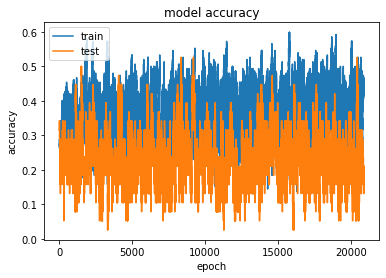

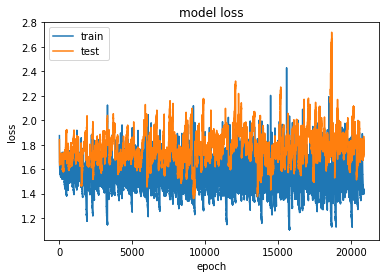

In [61]:
#  print(history.history.keys())
# summarize history for accuracy
plt.plot(hist_df['acc'])
plt.plot(hist_df['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
predictions = model.predict(x=X_test, batch_size=4, verbose=0) 
rounded_predictions = np.argmax(predictions, axis=-1)

In [43]:
# Values count
y_test = np.argmax(y_test, axis=-1)
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[0 5]
 [1 2]
 [2 2]
 [3 5]
 [4 8]]


In [44]:
print(rounded_predictions)
print(y_test)

[4 3 0 0 1 1 0 2 3 0 2 3 0 4 3 2 2 0 1 0 1 0]
[4 2 0 2 1 4 3 0 0 4 3 3 4 4 3 4 3 0 4 4 1 0]


In [45]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [46]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
print(cm)

[[3 0 1 1 0]
 [0 2 0 0 0]
 [1 0 0 1 0]
 [1 0 2 2 0]
 [3 2 1 0 2]]


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 0 1 1 0]
 [0 2 0 0 0]
 [1 0 0 1 0]
 [1 0 2 2 0]
 [3 2 1 0 2]]


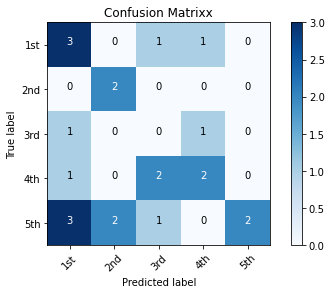

In [48]:
cm_plot_labels = ['1st','2nd','3rd','4th','5th']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrixx')

In [1]:
data

NameError: name 'data' is not defined